<h1> Vorbereitung

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np



In [3]:
# DFs einlesen
df_training_all_features = pd.read_parquet(
    "../data/processed/df_training_all_features.parquet"
)
df_test_all_features = pd.read_parquet(
    "../data/processed/df_test_all_features.parquet"
)

Funktion definieren, die Modellprediction evaluiert und in ein Dataframe schreibt

In [2]:
# Globales DataFrame zur Speicherung der Ergebnisse
results_df = pd.DataFrame(columns=["Durchlauf", "Modell", "Accuracy", "F1 Score"])

def log_model_performance(durchlauf_name: str, model_name: str, y_pred, y_test):
    """
    Berechnet Accuracy und F1-Score anhand von y_test und y_pred und
    fügt die Ergebnisse dem globalen DataFrame results_df hinzu.
    
    Parameter:
      - durchlauf_name: Name des Durchlaufs (String)
      - model_name: Name des verwendeten Modells (String)
      - y_pred: Vorhersagen des Modells
      - y_test: Wahre Zielwerte
      
    Gibt zurück:
      - Das aktualisierte DataFrame mit den Spalten "Durchlauf", "Modell", "Accuracy" und "F1 Score"
    """
    global results_df
    # Berechnung der Metriken
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Neuen Eintrag als DataFrame erstellen
    new_row = pd.DataFrame({
        "Durchlauf": [durchlauf_name],
        "Modell": [model_name],
        "Accuracy": [acc],
        "F1 Score": [f1]
    })
    
    # Ergebnisse zum globalen DataFrame hinzufügen
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    return results_df

<h1> Marios Teil (Ensembe Methoden)


<h1> Gradient Boosting: XGBOOST

In [6]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3> XGBoost Baseline

In [5]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Baseline", y_pred = y_pred, y_test = y_test)
df_results


C:\Users\mario\AppData\Local\Temp\ipykernel_2008\1598733018.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377


<h2> Feature Selection

<h3> Feature Importance

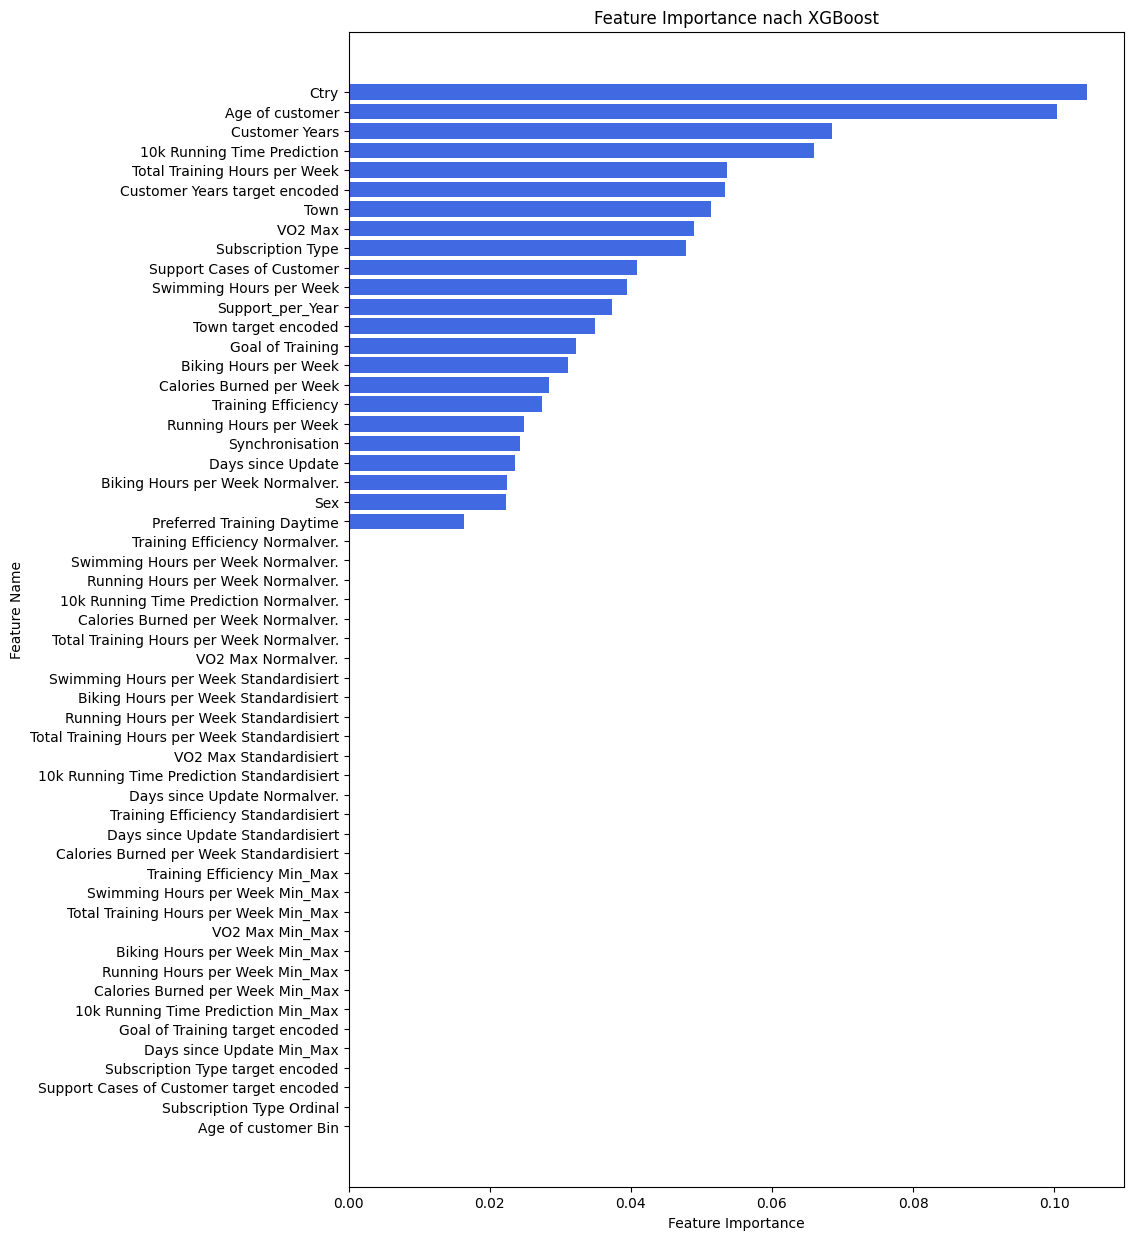

In [6]:
# Feature-Wichtigkeiten abrufen
importances = model.feature_importances_
feature_names = X_train.columns

# In DataFrame umwandeln und sortieren
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Visualisieren
plt.figure(figsize=(10,15))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance nach XGBoost")
plt.gca().invert_yaxis()
plt.show()

Wie man sieht, gibt es einige Features, deren Featureimportance Null beträgt. Diese werden im nächsten Schrill entfernt und das Modell neu trainiert.

In [7]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Begrenzung auf Features mit Feature Importance > 0
X_train = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]
X_test = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Featureimportance > 0 (new Baseline)", y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774


<!-- Die Entfernung der Features ohne Featureimportance hat das Modell verbessert.
Daher wird dieser Stand als neue Baseline für zukünftige Vergleiche genutzt.
Nun werden die numerischen Features mit dem ANOVA F-Score analysiert: -->

Das Entfernen der Features mit einer Featureimportance von Null hat das Modell verbessert.

Daher wird dieses Modell als neue Baseline für künftige Vergleiche genutzt.

Nun werden die numerischen Werte mit dem Anova F-Score analysiert:

<h3> Anova F-Score (für numerische Features)

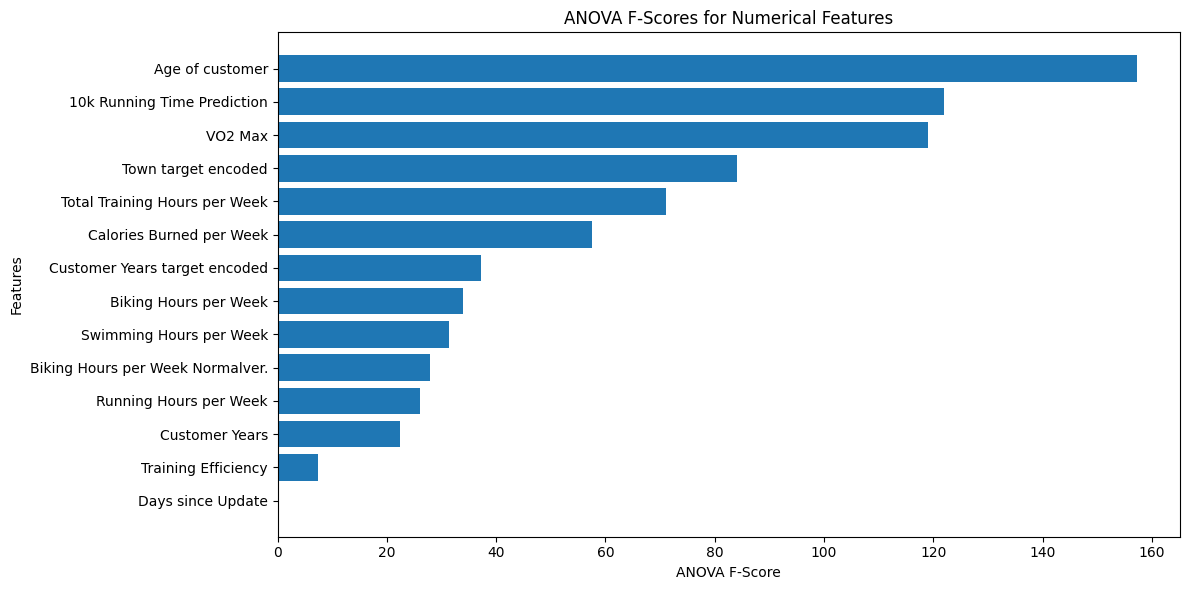

In [8]:
# Get numerical features that have non-zero importance
numerical_features = feature_importance_df[
    (feature_importance_df['Importance'] > 0) & 
    (~feature_importance_df['Feature'].isin(['Sex', 'Ctry', 'Town', 'Goal of Training', 
                                           'Preferred Training Daytime', 'Subscription Type', 
                                           'Synchronisation', "Support Cases of Customer", "Support_per_Year"]))
]['Feature'].values

# Calculate F-scores
X_numerical = X_train[numerical_features]
f_scores, p_values = f_classif(X_numerical, y_train)

# Create DataFrame with results
anova_results = pd.DataFrame({
    'Feature': numerical_features,
    'F_Score': f_scores,
    'p_value': p_values
})

# Sort by F-score
anova_results = anova_results.sort_values('F_Score', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
plt.barh(anova_results['Feature'], anova_results['F_Score'])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Features')
plt.title('ANOVA F-Scores for Numerical Features')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

Interpretation des ANOVA F-Scores
- Hoher F-Score: Ein hoher Wert deutet darauf hin, dass das Feature einen großen Unterschied zwischen den Gruppen (Zielklassen) macht. Das Feature ist also wahrscheinlich wichtig für das Modell.
- Niedriger F-Score: Ein niedriger Wert deutet darauf hin, dass das Feature nicht wirklich zwischen den Gruppen unterscheidet und somit weniger informativ ist.

- Days since update hat einen Anova F-Score von 0 und war auch bei der Featureimportance nicht besonders wichtig -> wird entfernt
- Training Efficiency hat einen niedrigen Anova F-Score und eine relativ niedrige Featureimportance -> wird entfernt
- Customer Years hat einen recht geringen Anova F-Score, aber eine hohe Featureimportance (der geringe Anova F-Score entsteht wahrscheinlich, weil es nur 12 einizartige Werte in diesem Feature gibt) -> wird nicht entfernt

In [9]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Begrenzung auf Features mit Feature Importance > 0
X_train_temp = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Days since Update", "Training Efficiency"], axis=1)
X_test_temp = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Days since Update", "Training Efficiency"], axis=1)

for col in categorical_cols:
    X_train_temp[col] = X_train_temp[col].astype("category")
    X_test_temp[col] = X_test_temp[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train_temp, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test_temp)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Anova F-Score", y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351


Das entfernen der beiden Features mit dem niedrigen Anova F-Score hat das Modell verschelchtert. Daher werden diese Features in Zukunft weiterhin für das Training benutzt.

<h3> Chi-Quadrat Test für kategorische Features

C:\Users\mario\AppData\Local\Temp\ipykernel_2008\3670157174.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi_square_results = pd.concat([chi_square_results, new_row], ignore_index=True)


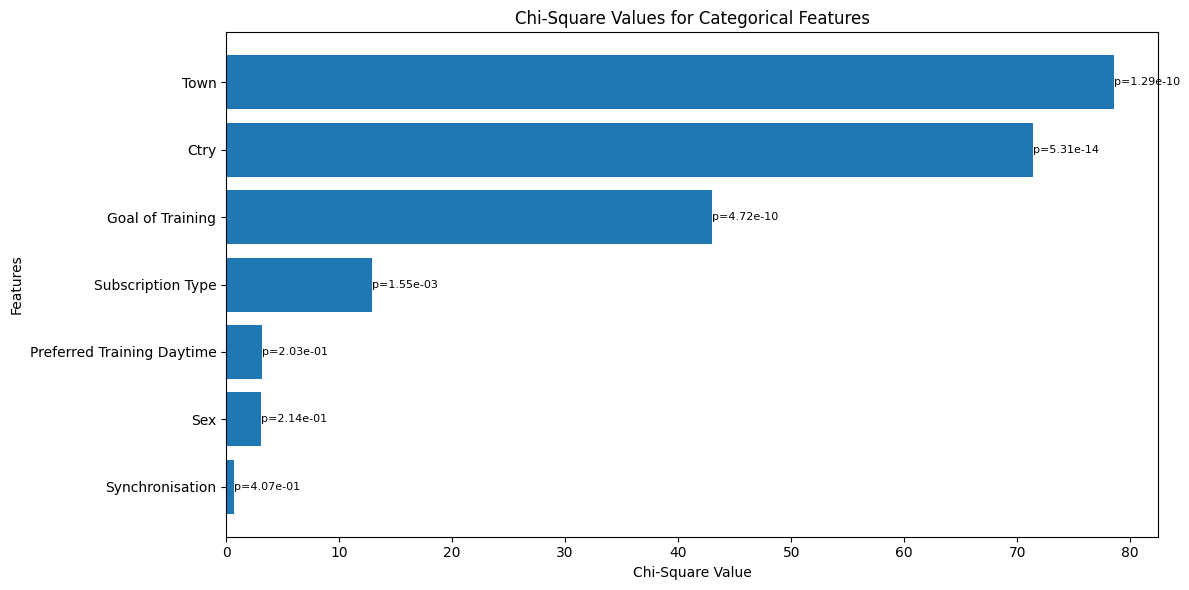

In [10]:
from scipy.stats import chi2_contingency

# Get only categorical columns from X_test
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                   "Preferred Training Daytime", "Subscription Type", "Synchronisation"]
X_test_categorical = X_test[categorical_cols]

# Initialize a DataFrame to store chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'p-value'])

# Get categorical features from X_test_categorical
for feature in categorical_cols:
    # Create contingency table
    contingency = pd.crosstab(X_train[feature], y_train)
    
    # Perform chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    # Add results to DataFrame
    new_row = pd.DataFrame({
        'Feature': [feature],
        'Chi-Square': [chi2],
        'p-value': [p_value]
    })
    chi_square_results = pd.concat([chi_square_results, new_row], ignore_index=True)

# Sort by Chi-Square value
chi_square_results = chi_square_results.sort_values('Chi-Square', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
bars = plt.barh(chi_square_results['Feature'], chi_square_results['Chi-Square'])
plt.xlabel('Chi-Square Value')
plt.ylabel('Features')
plt.title('Chi-Square Values for Categorical Features')

# Add p-values to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    p_value = chi_square_results.iloc[i]['p-value']
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'p={p_value:.2e}', 
             va='center',
             fontsize=8)

plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

- Ein hoher Chi-Square-Wert bedeutet, dass es eine starke Abhängigkeit zwischen dem Feature und der Zielvariable gibt → Das Feature ist potenziell wichtig für die Klassifikation.
- Ein niedriger Chi-Square-Wert bedeutet, dass das Feature kaum oder keinen Zusammenhang mit der Zielvariable hat → Wenig Einfluss auf die Klassifikation.
p-Wert ergänzt die Analyse:
- p < 0.05 → Statistisch signifikanter Zusammenhang (Feature relevant)
- p ≥ 0.05 → Kein signifikanter Zusammenhang (Feature wahrscheinlich unwichtig)

Synchronisation, Sex und Preferred Training Daytime haben ein geringen Chi-Square-Value und einen p-Wert von über 0.05 und werden daher entfernt

In [11]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Ctry", "Town", "Goal of Training", "Subscription Type"]

# Begrenzung auf Features mit Feature Importance > 0
X_train_temp = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Preferred Training Daytime"], axis=1)
X_test_temp = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Preferred Training Daytime"], axis=1)

for col in categorical_cols:
    X_train_temp[col] = X_train_temp[col].astype("category")
    X_test_temp[col] = X_test_temp[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",
    enable_categorical=True
)
model.fit(X_train_temp, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test_temp)

df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Chi Square", y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500


Das Entfernen der Features mit einem geringen Chi-Squared Wert hat das Modell verschlechtert (auch das entfernen einzelner Features). Daher werden diese Features beibehalten.

Grund für die Verschlechtrerung könnte sein, dass es eine nicht-lineare Abhängigkeit gibt (Chi-Square-Test erfasst nur lineare abhängigkeiten.)

<h3> Featureselection Fazit

Der Analyse nach zu Urteilen sind die besten Features alle Features, deren Feature_importance nicht Null ist!


<h2> Hyperparameter Tuning

Das Hyperparameter Tuning wird mit RandomizedSerchCV (zufällige Suche anhand gegebener Parameter) durchgeführt.
Das Hyperparameter Tuning ist rechenintensiv und dauert etwas.

In [12]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Kategorische Spalten definieren und konvertieren
categorical_cols = [
    "Sex", "Ctry", "Town", "Goal of Training", 
    "Preferred Training Daytime", "Subscription Type", "Synchronisation"
]

# Features filtern
X_train = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]
X_test = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]

# Spalten in kategorischen Typ umwandeln
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Parameterverteilungen für die Suche
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11],
    'learning_rate': loguniform(1e-3, 0.3),
    'n_estimators': [50, 100, 200, 300],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': [1, 2, 3, 4]
}

# Baseline-Modell mit kategorischem Support
model = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",
    enable_categorical=True,
    eval_metric="logloss"
)

# Randomized Search mit 50 Iterationen und 5-Fold-CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Hyperparameter-Suche auf Trainingsdaten durchführen
random_search.fit(X_train, y_train)

# Bestes Modell ausgeben
best_params = random_search.best_params_
print("Beste Parameter:", best_params)

best_model = random_search.best_estimator_

# Vorhersagen mit dem optimierten Modell
y_pred_tuned = best_model.predict(X_test)

# Modellperformance berechnen
df_results = log_model_performance(
    model_name="XGBoost", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred_tuned, 
    y_test=y_test
)

df_results

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Beste Parameter: {'colsample_bytree': np.float64(0.8623697656280125), 'gamma': np.float64(0.05228386560109033), 'learning_rate': np.float64(0.05357363643123652), 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': np.float64(0.620685730324957)}


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.764103,0.708861


Das Hyperparameter Tuning hat das Modell weiter verbessert!
Die folgenden Parameter haben eine Accuracy von 0.784615 erzielt:

 Beste Parameter: {'colsample_bytree': np.float64(0.6553459284957908), 'gamma': np.float64(0.21227756046053303), 'learning_rate': np.float64(0.044604646959992715), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': np.float64(0.6630244246750918)} 

<h1> Adaptive Boosting: AdaBoost </h1>
Ein Ensemble-Modell kombiniert mehrere schwache Modelle (z. B. Decision Trees) zu einem stärkeren Modell, um die Vorhersage zu verbessern.

In [14]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3> Adaboost Baseline

In [15]:
# Select only numerical columns for X
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_num = X_train[numerical_cols]
X_test_num = X_test[numerical_cols]

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_num, y_train)

# Make predictions
y_pred = model.predict(X_test_num)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Baseline", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.764103,0.708861
5,Baseline,AdaBoost,0.728205,0.653595


<h2> Feature Selection

<h3> Feature importance

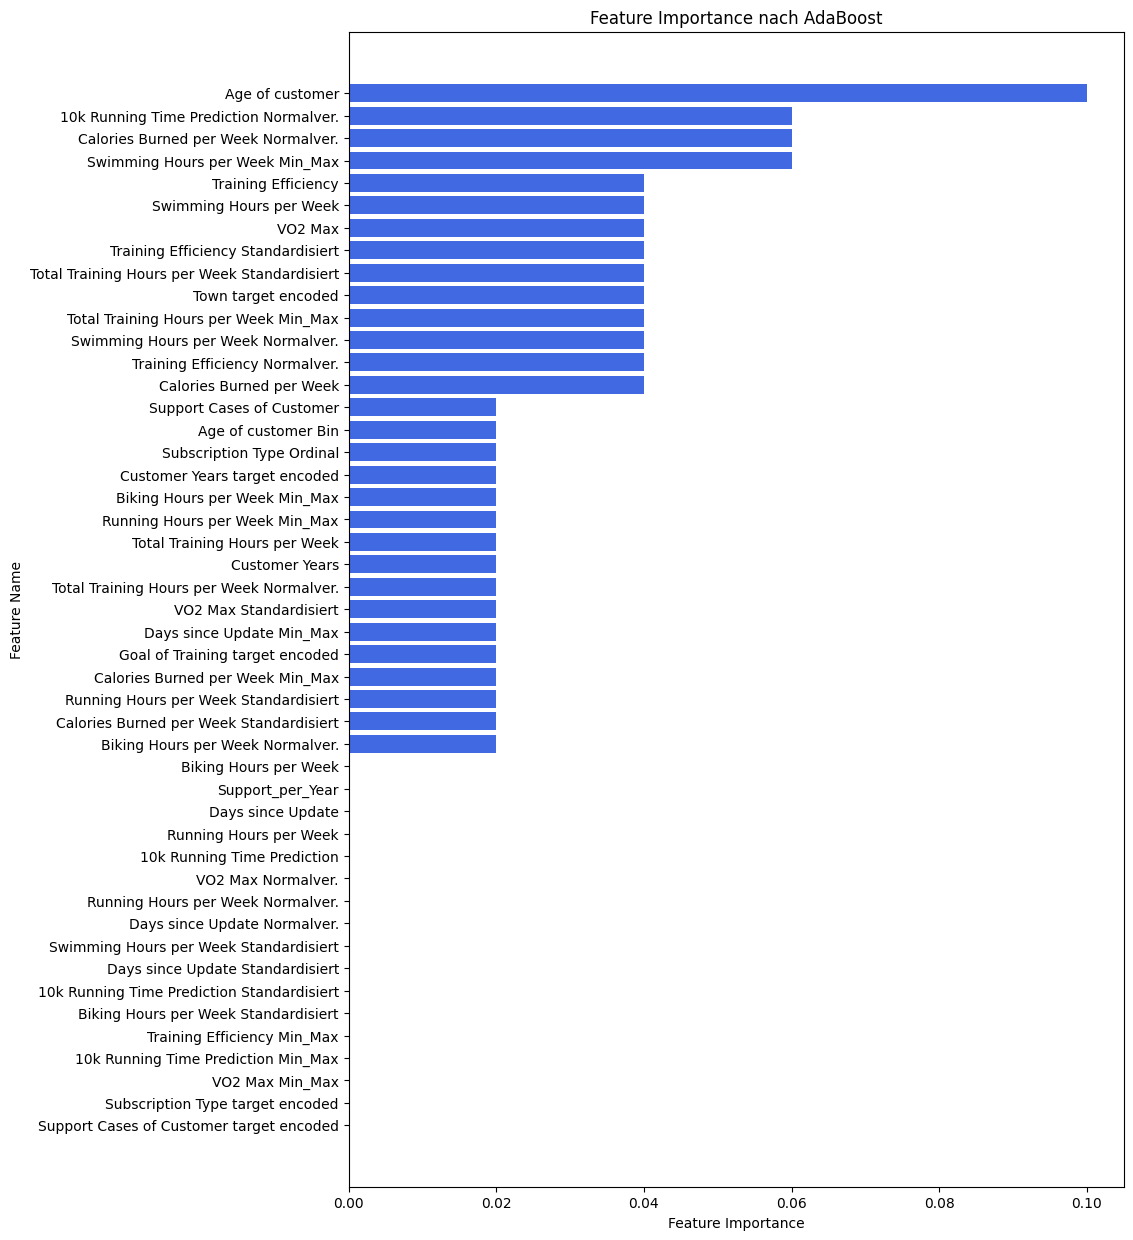

In [16]:
# Get feature importances from AdaBoost model
importances = model.feature_importances_
feature_names = X_train_num.columns

# Create DataFrame with feature importances and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10,15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance nach AdaBoost')
plt.gca().invert_yaxis()
plt.show()

In [17]:
# Get features with non-zero importance from feature importance DataFrame
non_zero_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].values

# Create new training and test sets with selected features
X_train_selected = X_train[non_zero_features]
X_test_selected = X_test[non_zero_features]

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Featureimportance > 0", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.764103,0.708861
5,Baseline,AdaBoost,0.728205,0.653595
6,Featureimportance > 0,AdaBoost,0.728205,0.653595


Die Entfernung der Features mit einer Featureimportance von Null hat das Modell nicht verbessert.

<h3> Anova F-Score

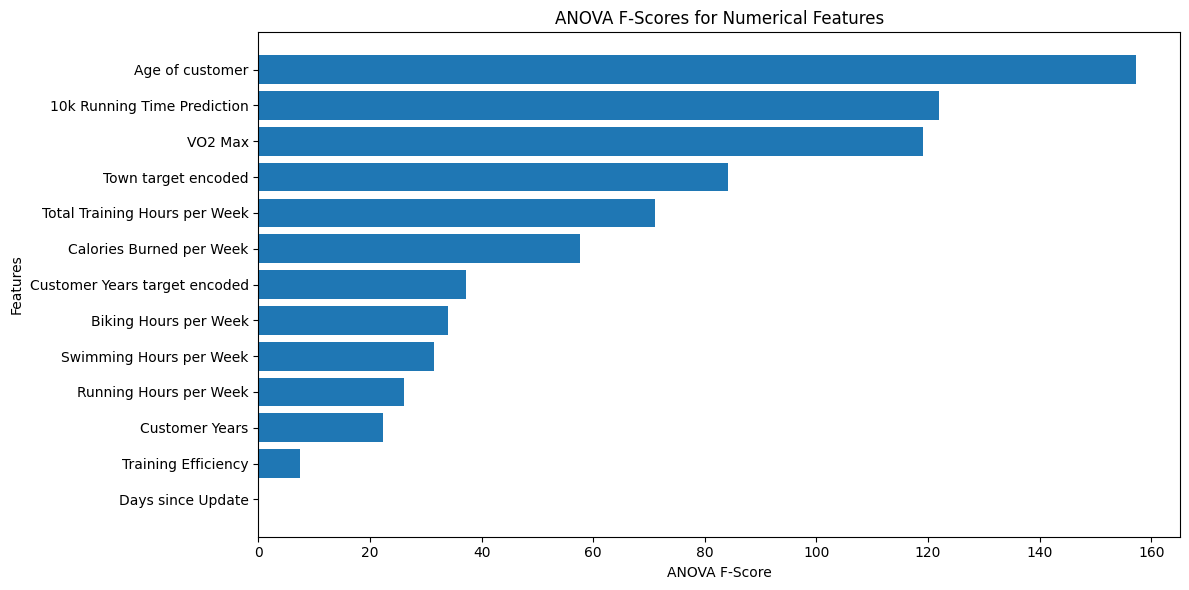

In [18]:
# Get numerical features from X_train
numerical_features = ['Age of customer', 'Customer Years', '10k Running Time Prediction',
                     'Total Training Hours per Week', 'Customer Years target encoded',
                     'VO2 Max', 'Swimming Hours per Week', 'Town target encoded',
                     'Biking Hours per Week', 'Calories Burned per Week',
                     'Training Efficiency', 'Running Hours per Week',
                     'Days since Update']

# Calculate F-scores
X_numerical = X_train[numerical_features]
f_scores, p_values = f_classif(X_numerical, y_train)

# Create DataFrame with results
anova_results = pd.DataFrame({
    'Feature': numerical_features,
    'F_Score': f_scores,
    'p_value': p_values
})

# Sort by F-score
anova_results = anova_results.sort_values('F_Score', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
plt.barh(anova_results['Feature'], anova_results['F_Score'])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Features')
plt.title('ANOVA F-Scores for Numerical Features')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

Days since Update hat einen Anova F-Score von 0 und Training Efficiency hat einen sehr geringen Wert, daher werden diese beiden Features entfernt:

In [19]:
# Select only numerical columns for X
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_num = X_train[numerical_cols].drop(columns=["Days since Update", "Training Efficiency"], axis=1)
X_test_num = X_test[numerical_cols].drop(columns=["Days since Update", "Training Efficiency"], axis=1)

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_num, y_train)

# Make predictions
y_pred = model.predict(X_test_num)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Anova F-Score", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.764103,0.708861
5,Baseline,AdaBoost,0.728205,0.653595
6,Featureimportance > 0,AdaBoost,0.728205,0.653595
7,Anova F-Score,AdaBoost,0.728205,0.653595


Das entfernen der beiden Features hat das Modell nicht verbessert, daher werden die Features beibehalten.

<h3> Featureselection Fazit </h3>
Das Baseline Model konnte durch Feature Selection nicht weiter optimiert werden. Daher sind für den Adaboost Algorithmus alle numerischen Features geeignet.

<h2> Hyperparameter Tuning

In [20]:
# Definiere den Base Estimator (Decision Tree)
base_estimator = DecisionTreeClassifier()

# Hyperparameter-Suchraum
tuned_parameters = {
    'n_estimators': np.arange(50, 500, 50),  # Anzahl der schwachen Learner
    'learning_rate': np.logspace(-3, 1, 10),  # Lernrate
    'estimator': [
        DecisionTreeClassifier(max_depth=d) for d in range(1, 6)  # Tiefe des Base Estimators
    ]
}

# AdaBoost-Modell erstellen
adaboost = AdaBoostClassifier(random_state=42)

# RandomizedSearchCV für schnelleres Tuning
random_search = RandomizedSearchCV(
    estimator=adaboost,
    param_distributions=tuned_parameters,
    n_iter=20,
    scoring='accuracy', 
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Suche ausführen
random_search.fit(X_train_num, y_train)

# Bestes Modell und Parameter anzeigen
print("Beste Hyperparameter:", random_search.best_params_)
print("Beste Accuracy:", random_search.best_score_)

# Modell mit besten Parametern trainieren
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_num)

# Performance loggen
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred, 
    y_test=y_test
)
df_results


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Beste Hyperparameter: {'n_estimators': np.int64(300), 'learning_rate': np.float64(0.05994842503189409), 'estimator': DecisionTreeClassifier(max_depth=2)}
Beste Accuracy: 0.7602729528535981


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.764103,0.708861
5,Baseline,AdaBoost,0.728205,0.653595
6,Featureimportance > 0,AdaBoost,0.728205,0.653595
7,Anova F-Score,AdaBoost,0.728205,0.653595
8,Hyperparameter-Tuning,AdaBoost,0.748718,0.679739


Das Hyperparameter Tuning hat das Modell weiter verbessert!

# Michelle Teil

- Was ist mit den 20 Zeilen im Test Datensatz passiert
- Was soll das nan bei Ctry und Town? Ist nicht offiziell missing aber wo ist das dann reingekommen

In [85]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score    
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier

import importlib
import utils
# Cache-Probleme umgehen
importlib.reload(utils)

from utils import train_baseline_model
from utils import plot_feature_importance
from utils import evaluate_best_feature_combination
from utils import forward_selection
from utils import plot_permutation_importance

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Unterdrücke FutureWarnings (z.B. von Pandas)
warnings.filterwarnings("ignore", category=FutureWarning)

# Unterdrücke ConvergenceWarnings (z.B. von scikit-learn)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Allgemeine Übersicht über den aktuellen Stand der Daten

In [5]:
# DFs einlesen
df_training_all_features = pd.read_parquet(
    "../data/processed/df_training_all_features.parquet"
)
df_test_all_features = pd.read_parquet(
    "../data/processed/df_test_all_features.parquet"
)

In [6]:
df_training_all_features.shape

(971, 55)

In [7]:
df_test_all_features.shape

(480, 55)

Mit 971 Samples in den Trainingsdaten ist darauf zu achten, dass nur Modelle gewählt werden, die auch mit Datenmengen unter 1000 umgehen können ohne in das Problem Overfitting zu kommen.

In [8]:
df_training_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 971 entries, C0001 to C1000
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Age of customer                               971 non-null    float64
 1   Sex                                           971 non-null    object 
 2   Ctry                                          971 non-null    object 
 3   Town                                          971 non-null    object 
 4   Swimming Hours per Week                       971 non-null    float64
 5   Biking Hours per Week                         971 non-null    float64
 6   Running Hours per Week                        971 non-null    float64
 7   Total Training Hours per Week                 971 non-null    float64
 8   VO2 Max                                       971 non-null    float64
 9   10k Running Time Prediction                   971 non-null    fl

In [9]:
df_test_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, C0001 to C0500
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Age of customer                               480 non-null    float64
 1   Sex                                           480 non-null    object 
 2   Ctry                                          480 non-null    object 
 3   Town                                          480 non-null    object 
 4   Swimming Hours per Week                       480 non-null    float64
 5   Biking Hours per Week                         480 non-null    float64
 6   Running Hours per Week                        480 non-null    float64
 7   Total Training Hours per Week                 480 non-null    float64
 8   VO2 Max                                       480 non-null    float64
 9   10k Running Time Prediction                   480 non-null    fl

In [10]:
df_training_all_features['User of latest model'].value_counts()

User of latest model
0.0    568
1.0    403
Name: count, dtype: int64

Es besteht ein ausgeglichenes Klassenverhältnis des Labels. Das ist positiv für viele Modelle, da es für gewöhnlich für Probleme sorgt, wenn eine Klasse unterrepräsentiert ist.

## Erneute EDA für die Identifizierung von Zusammenhängen zum Label und untereinander  
Aus der EDA ist bereits bekannt, dass folgende Label einen eher höheren Zusammenhang mit den Label haben:  
`Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`,`Running Hours per Week`, `Total Training Hours per Week`, `VO2 Max`, `10k Running Time Prediction`, `Calories Burned per Week`, `Support Cases of Customer`, `Customer Years`, `Ctry`, `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years`  

Allerdings wurde die EDA vor der umfangreichen Transformation der Daten durchgeführt, weshalb sich die Zusammenhänge möglicherweise verändert haben. Daher werden erneut ein paar Tests durchgeführt. Dadurch sollen wichtige Erkenntnisse für die Feature Selection gewonnen werden.


In [11]:
df_training_all_features.head()

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,...,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max,Town target encoded,Goal of Training target encoded,Subscription Type target encoded,Support Cases of Customer target encoded,Customer Years target encoded,Subscription Type Ordinal,Age of customer Bin
ID,,,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,...,0.832894,0.178371,0.363839,0.304348,0.345238,0.361765,0.423077,0.565217,1,9
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,...,0.665525,0.596683,0.524554,0.383333,0.345238,0.480363,0.423077,0.565217,3,8
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,...,0.126516,0.816899,0.308036,0.265625,0.590759,0.361765,0.423077,0.540541,1,2
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,...,0.417765,0.300542,0.319196,0.366667,0.325301,0.480363,0.437186,0.540541,3,0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,...,0.878756,0.271864,0.098214,0.271186,0.325301,0.403333,0.437186,0.376147,2,9


In [12]:
numerical_cols = df_training_all_features.select_dtypes(include=['number']).columns
numeric_features = df_training_all_features[numerical_cols].drop(columns=['User of latest model']).columns
print(numeric_features)
print("Anzahl numerischer Features:", len(numeric_features))

Index(['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week',
       'Running Hours per Week', 'Total Training Hours per Week', 'VO2 Max',
       '10k Running Time Prediction', 'Calories Burned per Week',
       'Support Cases of Customer', 'Customer Years', 'Days since Update',
       'Training Efficiency', 'Support_per_Year',
       'Training Efficiency Normalver.', 'Swimming Hours per Week Normalver.',
       'Biking Hours per Week Normalver.', 'Running Hours per Week Normalver.',
       'Total Training Hours per Week Normalver.', 'VO2 Max Normalver.',
       '10k Running Time Prediction Normalver.',
       'Calories Burned per Week Normalver.', 'Days since Update Normalver.',
       'Training Efficiency Standardisiert',
       'Swimming Hours per Week Standardisiert',
       'Biking Hours per Week Standardisiert',
       'Running Hours per Week Standardisiert',
       'Total Training Hours per Week Standardisiert',
       'VO2 Max Standardisiert', '10k Running Time 

In [13]:
categorical_features = df_training_all_features.select_dtypes(include=['object', 'category']).columns
print(categorical_features)
print("Anzahl kategorischer Features:", len(categorical_features))

Index(['Sex', 'Ctry', 'Town', 'Goal of Training', 'Preferred Training Daytime',
       'Subscription Type', 'Synchronisation'],
      dtype='object')
Anzahl kategorischer Features: 7


In [14]:
label = "User of latest model"
y_label = df_training_all_features[label]
features = df_training_all_features.drop(columns=[label])

In [15]:
unique_counts_df = pd.DataFrame({
    "Spalte": df_training_all_features.columns,
    "Anzahl_eindeutiger_Werte": [df_training_all_features[col].nunique() for col in df_training_all_features.columns],
    "Datentyp": [df_training_all_features[col].dtype for col in df_training_all_features.columns]
})

unique_counts_df.sort_values(by="Anzahl_eindeutiger_Werte", ascending=True)

,Spalte,Anzahl_eindeutiger_Werte,Datentyp
17,User of latest model,2,float64
16,Synchronisation,2,object
1,Sex,3,object
13,Goal of Training,3,object
15,Subscription Type,3,object
14,Preferred Training Daytime,3,object
53,Subscription Type Ordinal,3,int64
50,Subscription Type target encoded,3,float64
49,Goal of Training target encoded,3,float64
51,Support Cases of Customer target encoded,5,float64


### Korrelation  
Analyse wird nur für die numerischen Spalten durchgeführt, die mehr als 20 eindeutige Werte haben. Auf diese sollte nur geschaut werden, wenn ein Modell verwendet wird, welches schlecht mit Multikollinearität umgehen kann.

In [16]:
filtered_df = unique_counts_df[unique_counts_df["Anzahl_eindeutiger_Werte"] > 20]
columns_with_more_than_20_unique = filtered_df["Spalte"].tolist()
df_corr = df_training_all_features[columns_with_more_than_20_unique]
df_corr.head()

,Age of customer,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Days since Update,Training Efficiency,...,Days since Update Standardisiert,Training Efficiency Min_Max,Swimming Hours per Week Min_Max,Biking Hours per Week Min_Max,Running Hours per Week Min_Max,Total Training Hours per Week Min_Max,VO2 Max Min_Max,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max
ID,,,,,,,,,,,,,,,,,,,,,
C0001,61.0,2.52,0.10,1.78,4.40,23.08,60.72,2329.950000,213.0,529.534091,...,-0.444098,0.837587,0.252758,0.006207,0.149958,0.162152,0.182878,0.832894,0.178371,0.363839
C0003,57.0,1.55,10.01,4.57,16.13,39.04,54.37,7904.930000,285.0,490.076255,...,0.114413,0.798457,0.155466,0.621353,0.385004,0.609691,0.409841,0.665525,0.596683,0.524554
C0004,30.0,1.19,12.04,8.64,21.87,71.59,33.92,10839.810000,188.0,495.647462,...,-0.638026,0.803982,0.119358,0.747362,0.727885,0.828691,0.872725,0.126516,0.816899,0.308036
C0005,21.0,2.25,4.67,0.92,7.84,49.09,44.97,3958.160897,193.0,504.867461,...,-0.599240,0.813125,0.225677,0.289882,0.077506,0.293399,0.552759,0.417765,0.300542,0.319196
C0006,63.0,0.80,5.88,0.67,7.35,13.91,62.46,3575.960000,94.0,486.525170,...,-1.367193,0.794935,0.080241,0.364991,0.056445,0.274704,0.052474,0.878756,0.271864,0.098214


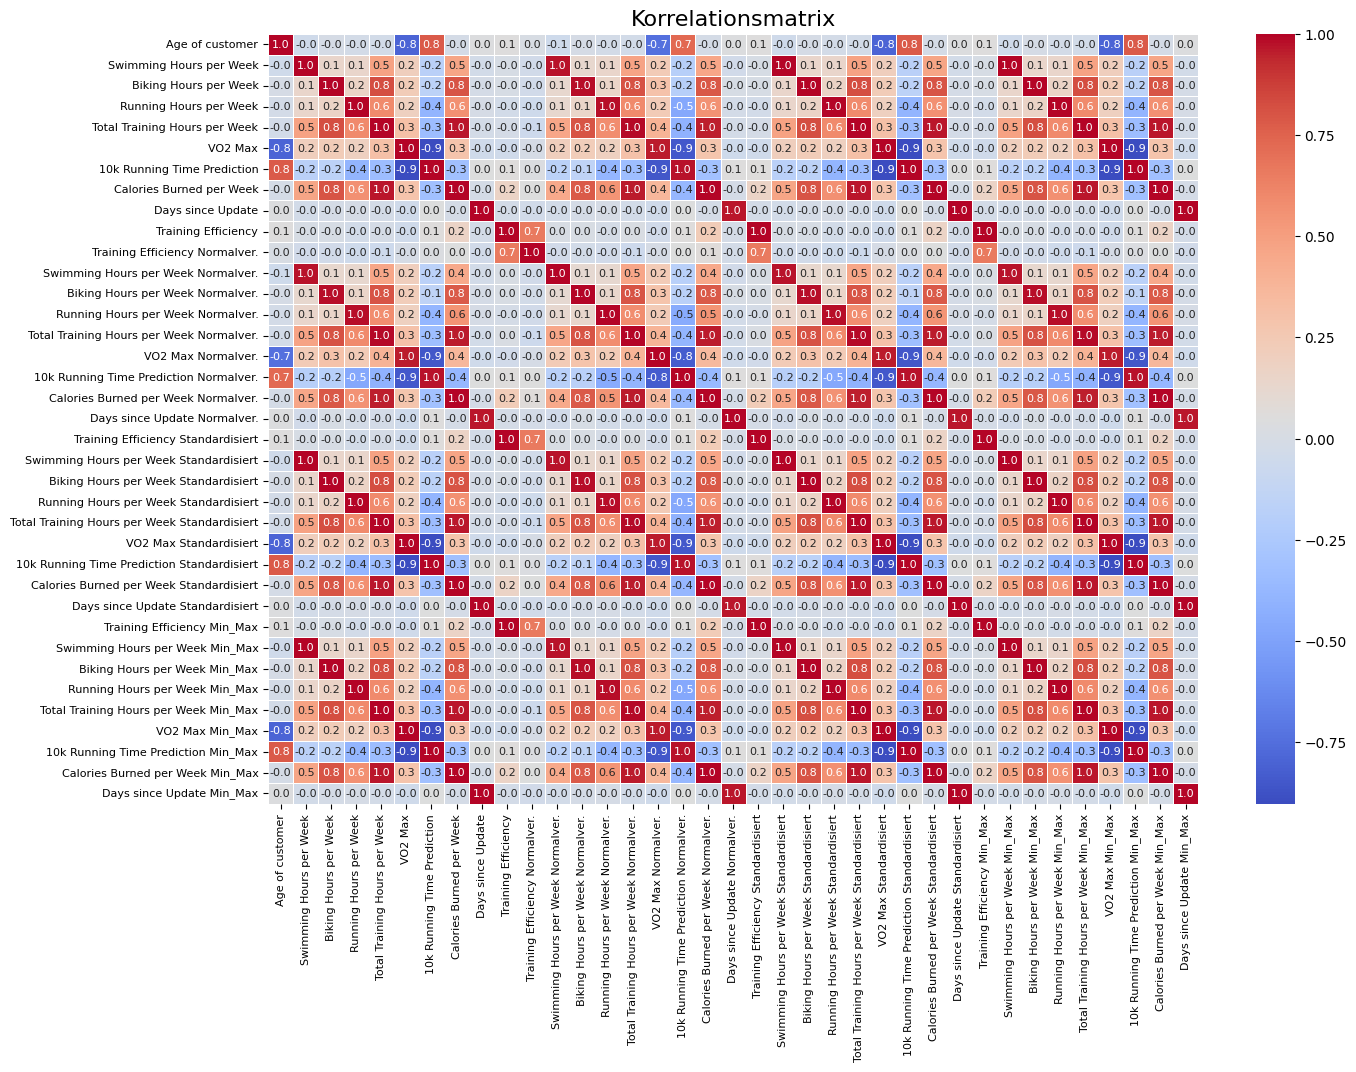

In [17]:
# Korrelationsmatrix berechnen
corr = df_corr.corr()

# Größe der Grafik anpassen
plt.figure(figsize=(15,10))  # Anpassen für bessere Sichtbarkeit

# Heatmap zeichnen mit angepasster Annotation-Größe
sns.heatmap(
    corr, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".1f", 
    linewidths=0.5, 
    annot_kws={"size": 8}  # Anpassung der Schriftgröße für Annotationen
)

# Achsenbeschriftungen drehen
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Titel hinzufügen
plt.title("Korrelationsmatrix", fontsize=16)

# Grafik anzeigen
plt.show()

### ANOVA Test

In [18]:
anova_p_values = pd.DataFrame(index=numeric_features, columns=['p-value'])
for i in numeric_features:
    data_anova = pd.concat([features[i], df_training_all_features[label]], axis=1)
    data_anova = data_anova.dropna()
    groups = []
    for j in data_anova[label].unique():
        groups.append(data_anova[data_anova[label]==j][i])
    stat, p = f_oneway(*groups)
    anova_p_values.loc[i,'p-value'] = p
anova_p_values.sort_values(by='p-value')

,p-value
Age of customer,0.0
VO2 Max Normalver.,0.0
Age of customer Bin,0.0
10k Running Time Prediction Normalver.,0.0
VO2 Max Standardisiert,0.0
VO2 Max,0.0
VO2 Max Min_Max,0.0
10k Running Time Prediction,0.0
10k Running Time Prediction Standardisiert,0.0
10k Running Time Prediction Min_Max,0.0


Training Efficiency sowie Days since Update sollten in jeglicher Form nicht als Feature integriert werden.

### Chi2 Test  
Der Test wird für alle kategorischen Spalten sowie Spalten mit unter 20 eindeutigen Werten durchgeführt.

In [19]:
non_cont_columns = df_training_all_features.columns[~df_training_all_features.columns.isin(columns_with_more_than_20_unique)]
non_cont_columns

Index(['Sex', 'Ctry', 'Town', 'Support Cases of Customer', 'Customer Years',
       'Goal of Training', 'Preferred Training Daytime', 'Subscription Type',
       'Synchronisation', 'User of latest model', 'Support_per_Year',
       'Town target encoded', 'Goal of Training target encoded',
       'Subscription Type target encoded',
       'Support Cases of Customer target encoded',
       'Customer Years target encoded', 'Subscription Type Ordinal',
       'Age of customer Bin'],
      dtype='object')

In [20]:
chi2_values = pd.DataFrame(index=non_cont_columns, columns=non_cont_columns)
for i in non_cont_columns:
    for j in non_cont_columns:
        df_chi2 = df_training_all_features[[i,j]]
        data_cont=pd.crosstab(df_chi2.iloc[:,0], df_chi2.iloc[:,1])
        stat, p, dof, expected = chi2_contingency(data_cont)
        chi2_values.loc[i,j] = p

<Axes: >

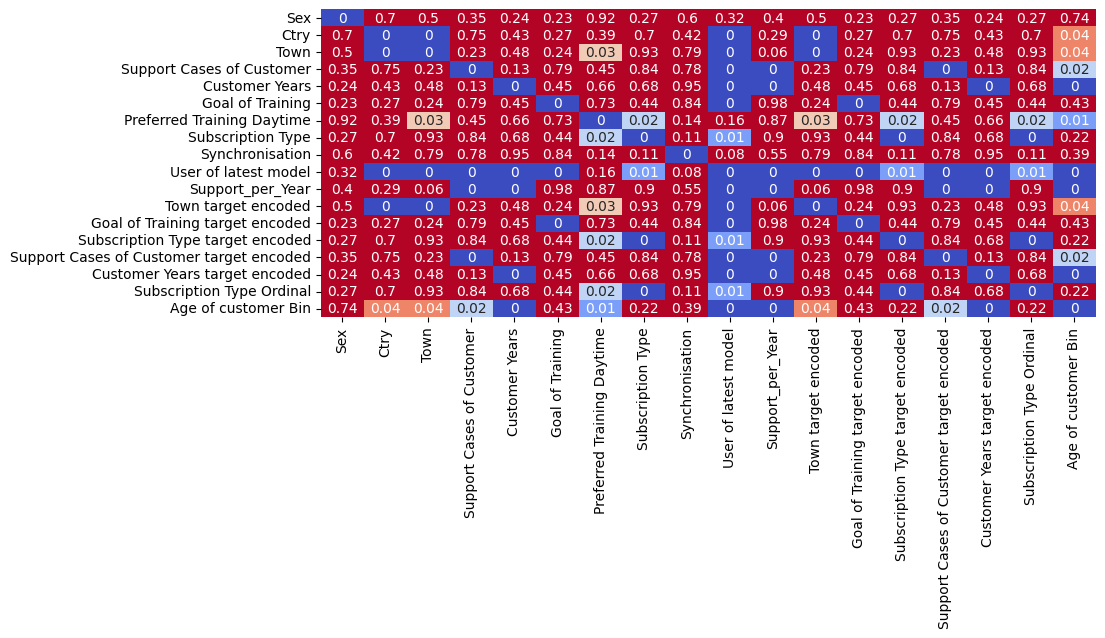

In [21]:
plt.figure(figsize=(10,4))
sns.heatmap(round(chi2_values.astype(float),2), annot=True, cmap='coolwarm', cbar=False, vmin=0, vmax=0.05)

Wie auch schon in der EDA zeigen die folgenden Spalten keinen Zusammenhang zum Label:  
`Synchronisation`, `Sex`, `Prefered Training Datetime`

### Zusammenfassung EDA

In [22]:
chi2 = pd.DataFrame(chi2_values['User of latest model'])
chi2.sort_values(by='User of latest model')

,User of latest model
User of latest model,0.0
Age of customer Bin,0.0
Ctry,0.0
Town,0.0
Town target encoded,0.0
Goal of Training,0.0
Goal of Training target encoded,0.0
Support_per_Year,0.000015
Customer Years,0.00005
Customer Years target encoded,0.00005


In [23]:
anova_p_values.sort_values(by='p-value')

,p-value
Age of customer,0.0
VO2 Max Normalver.,0.0
Age of customer Bin,0.0
10k Running Time Prediction Normalver.,0.0
VO2 Max Standardisiert,0.0
VO2 Max,0.0
VO2 Max Min_Max,0.0
10k Running Time Prediction,0.0
10k Running Time Prediction Standardisiert,0.0
10k Running Time Prediction Min_Max,0.0


In [24]:
eda_results = pd.concat([anova_p_values, chi2], axis=1)
eda_results.columns = ["ANOVA_p_Value", "Chi2_p_Value"]
eda_results = eda_results.drop("User of latest model", axis=0)
eda_results['Max_p_Value'] = eda_results.max(axis=1)
eda_results = eda_results.sort_values(by='Max_p_Value')
eda_results

,ANOVA_p_Value,Chi2_p_Value,Max_p_Value
Age of customer,0.0,NaN,0.0
VO2 Max Normalver.,0.0,NaN,0.0
10k Running Time Prediction Normalver.,0.0,NaN,0.0
VO2 Max Min_Max,0.0,NaN,0.0
VO2 Max,0.0,NaN,0.0
VO2 Max Standardisiert,0.0,NaN,0.0
10k Running Time Prediction Min_Max,0.0,NaN,0.0
10k Running Time Prediction,0.0,NaN,0.0
10k Running Time Prediction Standardisiert,0.0,NaN,0.0
Age of customer Bin,0.0,0.0,0.0


In [25]:
eda_results.index

Index(['Age of customer', 'VO2 Max Normalver.',
       '10k Running Time Prediction Normalver.', 'VO2 Max Min_Max', 'VO2 Max',
       'VO2 Max Standardisiert', '10k Running Time Prediction Min_Max',
       '10k Running Time Prediction',
       '10k Running Time Prediction Standardisiert', 'Age of customer Bin',
       'Total Training Hours per Week Min_Max',
       'Total Training Hours per Week Standardisiert',
       'Total Training Hours per Week',
       'Total Training Hours per Week Normalver.',
       'Calories Burned per Week Standardisiert', 'Calories Burned per Week',
       'Calories Burned per Week Min_Max', 'Ctry',
       'Calories Burned per Week Normalver.', 'Town', 'Town target encoded',
       'Goal of Training', 'Goal of Training target encoded',
       'Biking Hours per Week', 'Biking Hours per Week Min_Max',
       'Biking Hours per Week Standardisiert',
       'Biking Hours per Week Normalver.', 'Running Hours per Week Min_Max',
       'Running Hours per Week Stand

Nach der oben gezeigten Reihenfolge sollte die Feature Selection erfolgen  
`Synchronisation`, `Training Efficiency`, `Preferred Training Daytime`, `Sex` und `Days since Update` sollten bei der Feature-Auswahl nicht weiter in Betracht gezogen werden.

## Definition Variablen

In [26]:
df_training_all_features.head()

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,...,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max,Town target encoded,Goal of Training target encoded,Subscription Type target encoded,Support Cases of Customer target encoded,Customer Years target encoded,Subscription Type Ordinal,Age of customer Bin
ID,,,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,...,0.832894,0.178371,0.363839,0.304348,0.345238,0.361765,0.423077,0.565217,1,9
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,...,0.665525,0.596683,0.524554,0.383333,0.345238,0.480363,0.423077,0.565217,3,8
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,...,0.126516,0.816899,0.308036,0.265625,0.590759,0.361765,0.423077,0.540541,1,2
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,...,0.417765,0.300542,0.319196,0.366667,0.325301,0.480363,0.437186,0.540541,3,0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,...,0.878756,0.271864,0.098214,0.271186,0.325301,0.403333,0.437186,0.376147,2,9


In [27]:
df_training_all_features[df_training_all_features['Ctry'] == 'nan']

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,...,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max,Town target encoded,Goal of Training target encoded,Subscription Type target encoded,Support Cases of Customer target encoded,Customer Years target encoded,Subscription Type Ordinal,Age of customer Bin
ID,,,,,,,,,,,,,,,,,,,,,
C0145,28.0,Male,nan,Berlin,4.49,12.67,2.16,19.32,58.64,38.66,...,0.251450,0.714379,0.435268,0.373333,0.590759,0.480363,0.437186,0.565217,3,2
C0473,30.0,Other,nan,London,0.76,5.22,2.89,8.87,66.28,41.47,...,0.325514,0.333283,0.627232,0.313725,0.325301,0.480363,0.524590,0.396226,3,2
C0756,47.0,Other,nan,Brisbane,0.08,3.93,3.60,7.61,40.14,47.83,...,0.493147,0.311149,0.890625,0.460317,0.325301,0.480363,0.437186,0.434783,3,6
C0959,39.0,Male,nan,nan,0.78,8.00,0.93,9.71,58.05,41.80,...,0.334212,0.359838,0.910714,0.384615,0.325301,0.403333,0.423077,0.376147,2,4


In [28]:
df_training_all_features = df_training_all_features[df_training_all_features['Ctry'] != 'nan']

In [29]:
df_training_all_features[df_training_all_features['Town'] == 'nan']

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,...,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max,Town target encoded,Goal of Training target encoded,Subscription Type target encoded,Support Cases of Customer target encoded,Customer Years target encoded,Subscription Type Ordinal,Age of customer Bin
ID,,,,,,,,,,,,,,,,,,,,,
C0008,30.000000,Female,UK,nan,0.84,4.06,4.23,9.13,64.001225,36.56,...,0.196099,0.366388,0.743304,0.384615,0.325301,0.361765,0.524590,0.376147,1,2
C0021,60.000000,Male,India,nan,1.48,10.88,0.42,12.78,25.660000,61.16,...,0.844491,0.467582,0.933036,0.384615,0.590759,0.480363,0.524590,0.540541,3,9
C0125,43.000000,Other,Australia,nan,0.34,7.23,0.72,8.29,58.960000,48.30,...,0.505535,0.330255,0.683036,0.384615,0.345238,0.361765,0.437186,0.540541,1,5
C0136,43.000000,Other,UK,nan,2.99,0.63,2.27,5.89,45.980000,44.95,...,0.417238,0.213693,0.620536,0.384615,0.325301,0.361765,0.345000,0.434783,1,5
C0196,62.000000,Female,UK,nan,2.08,9.78,4.85,16.71,29.830000,56.29,...,0.716131,0.639500,0.819196,0.384615,0.345238,0.361765,0.437186,0.396226,1,9
C0217,53.212364,Female,India,nan,2.31,6.59,4.43,13.33,40.330000,52.93,...,0.627570,0.509013,0.526786,0.384615,0.345238,0.361765,0.345000,0.324675,1,7
C0230,38.000000,Other,UK,nan,1.84,3.69,1.01,6.54,58.590000,41.17,...,0.317607,0.252498,0.845982,0.384615,0.325301,0.361765,0.357488,0.434783,1,4
C0239,43.000000,Other,UK,nan,0.95,2.17,1.37,4.49,48.560000,47.85,...,0.493674,0.184099,0.100446,0.384615,0.325301,0.480363,0.437186,0.324675,3,5
C0247,39.000000,Other,Germany,nan,0.18,3.96,3.24,7.38,54.680000,42.75,...,0.359251,0.277489,0.044643,0.384615,0.325301,0.403333,0.437186,0.396226,2,4


In [30]:
df_training_all_features = df_training_all_features[df_training_all_features['Town'] != 'nan']

In [31]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Definition welche Feature prinzipiell das gleiche sind nur anders transformiert, damit bei der Feature Auswahl nur ein Feature der Gruppe ausgewählt wird
feature_groups = {
    'Age of customer': ['Age of customer', 'Age of customer Bin'],
    'Sex': ['Sex'],
    'Ctry': ['Ctry'],
    'Town': ['Town', 'Town target encoded'],
    'Swimming Hours': [
        'Swimming Hours per Week', 'Swimming Hours per Week Normalver.',
        'Swimming Hours per Week Standardisiert', 'Swimming Hours per Week Min_Max'
    ],
    'Biking Hours': [
        'Biking Hours per Week', 'Biking Hours per Week Normalver.',
        'Biking Hours per Week Standardisiert', 'Biking Hours per Week Min_Max'
    ],
    'Running Hours': [
        'Running Hours per Week', 'Running Hours per Week Normalver.',
        'Running Hours per Week Standardisiert', 'Running Hours per Week Min_Max'
    ],
    'Total Training Hours': [
        'Total Training Hours per Week', 'Total Training Hours per Week Normalver.',
        'Total Training Hours per Week Standardisiert', 'Total Training Hours per Week Min_Max'
    ],
    'VO2 Max': ['VO2 Max', 'VO2 Max Normalver.', 'VO2 Max Standardisiert', 'VO2 Max Min_Max'],
    '10k Running Time Prediction': [
        '10k Running Time Prediction', '10k Running Time Prediction Normalver.', 
        '10k Running Time Prediction Standardisiert', '10k Running Time Prediction Min_Max'
    ],
    'Calories Burned per Week': [
        'Calories Burned per Week', 'Calories Burned per Week Normalver.', 
        'Calories Burned per Week Standardisiert', 'Calories Burned per Week Min_Max'
    ],
    'Support Cases': ['Support Cases of Customer', 'Support Cases of Customer target encoded'],
    'Customer Years': ['Customer Years', 'Customer Years target encoded'],
    'Goal of Training': ['Goal of Training', 'Goal of Training target encoded'],
    'Preferred Training Daytime': ['Preferred Training Daytime'],
    'Subscription Type': ['Subscription Type', 'Subscription Type target encoded', 'Subscription Type Ordinal'],
    'Synchronisation': ['Synchronisation'],
    'Days since Update': [
        'Days since Update', 'Days since Update Normalver.', 'Days since Update Standardisiert', 'Days since Update Min_Max'
    ],
    'Training Efficiency': [
        'Training Efficiency', 'Training Efficiency Normalver.', 
        'Training Efficiency Standardisiert', 'Training Efficiency Min_Max'
    ],
    'Support per Year': ['Support_per_Year']
}


In [42]:
# In der Reihenfolge soll die Feature Selection durchgeführt werden - gemäß P-Wert
feature_order = ['Age of customer', 'VO2 Max Normalver.',
       '10k Running Time Prediction Normalver.', 'VO2 Max Min_Max', 'VO2 Max',
       'VO2 Max Standardisiert', '10k Running Time Prediction Min_Max',
       '10k Running Time Prediction',
       '10k Running Time Prediction Standardisiert', 'Age of customer Bin',
       'Total Training Hours per Week Min_Max',
       'Total Training Hours per Week Standardisiert',
       'Total Training Hours per Week',
       'Total Training Hours per Week Normalver.',
       'Calories Burned per Week Standardisiert', 'Calories Burned per Week',
       'Calories Burned per Week Min_Max', 'Ctry',
       'Calories Burned per Week Normalver.', 'Town', 'Town target encoded',
       'Goal of Training', 'Goal of Training target encoded',
       'Biking Hours per Week', 'Biking Hours per Week Min_Max',
       'Biking Hours per Week Standardisiert',
       'Biking Hours per Week Normalver.', 'Running Hours per Week Min_Max',
       'Running Hours per Week Standardisiert', 'Running Hours per Week',
       'Running Hours per Week Normalver.',
       'Swimming Hours per Week Normalver.', 'Swimming Hours per Week Min_Max',
       'Swimming Hours per Week', 'Swimming Hours per Week Standardisiert',
       'Support_per_Year', 'Customer Years target encoded', 'Customer Years',
       'Support Cases of Customer', 'Support Cases of Customer target encoded',
       'Subscription Type Ordinal', 'Subscription Type',
       'Subscription Type target encoded', 'Synchronisation',
       'Training Efficiency', 'Training Efficiency Standardisiert',
       'Training Efficiency Min_Max', 'Training Efficiency Normalver.',
       'Preferred Training Daytime', 'Sex', 'Days since Update Min_Max',
       'Days since Update Standardisiert', 'Days since Update',
       'Days since Update Normalver.']

## Lineare Modelle

### Logistische Regression  
Die logistische Regression ist ein statistisches Modell, das häufig für binäre Klassifikationsprobleme verwendet wird. Im Gegensatz zur linearen Regression, die kontinuierliche Werte vorhersagt, schätzt die logistische Regression die Wahrscheinlichkeit, dass eine Beobachtung zu einer bestimmten Klasse gehört. Sie verwendet die Sigmoid-Funktion, um Wahrscheinlichkeiten zu schätzen und ist interpretierbar sowie effizient bei kleineren Datensätzen.

#### Baseline

In [32]:
y_pred, model_name, run_name, model, x_train_encoded, original_columns = train_baseline_model(LogisticRegression(random_state=42), X_train, y_train, X_test)

In [33]:
df_results = log_model_performance(model_name= model_name, durchlauf_name=run_name, y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862


#### Feature Selection  

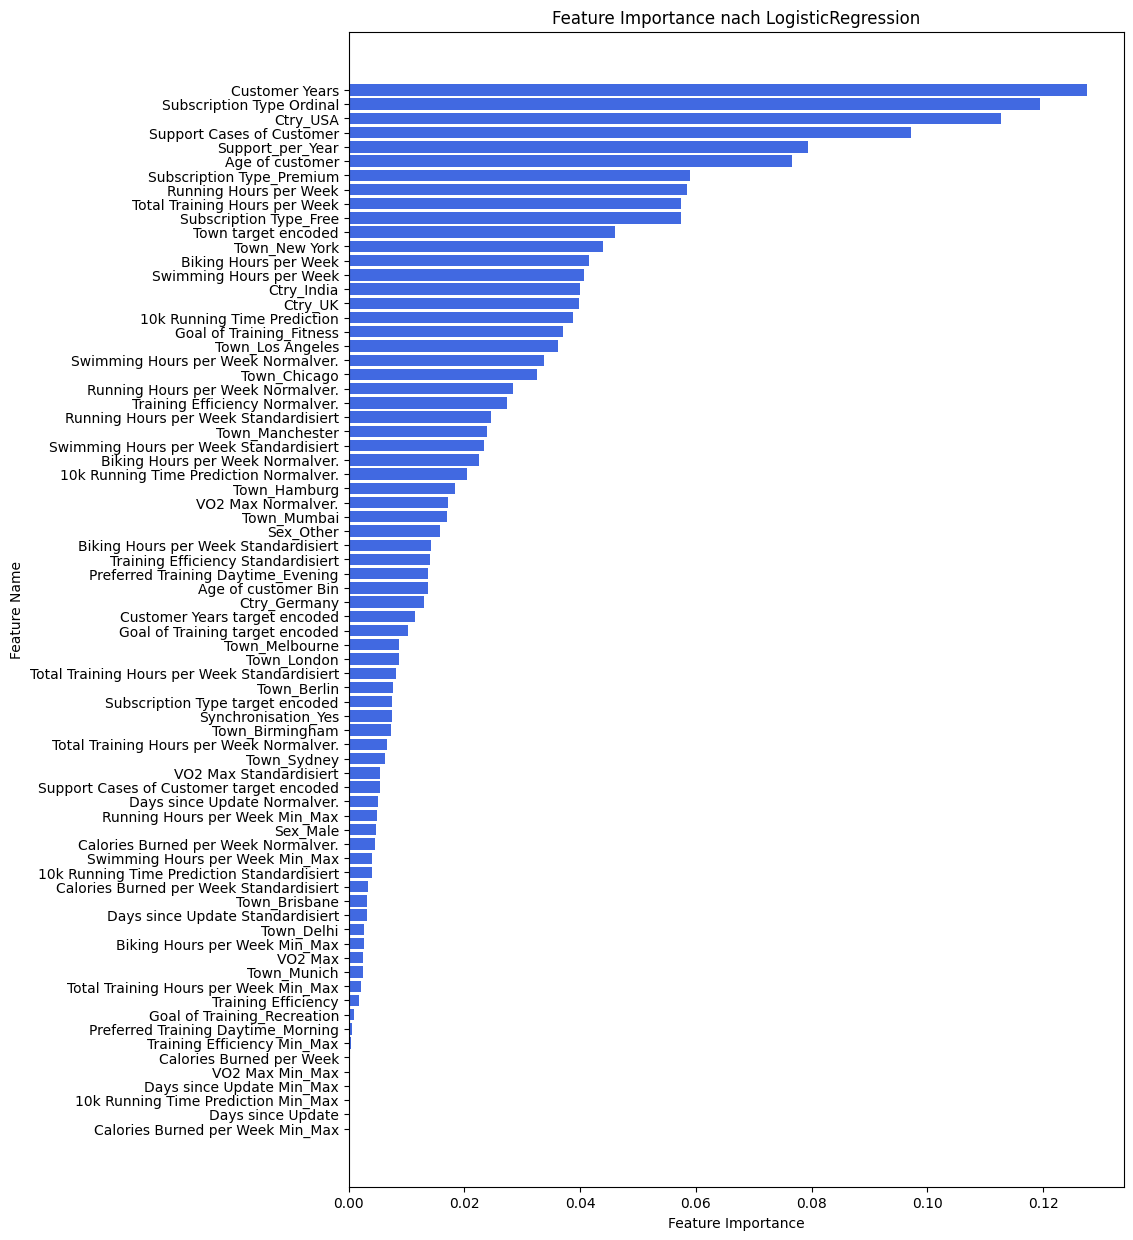

In [34]:
feature_importance_df = plot_feature_importance(model = model, X_train = x_train_encoded, model_name = model_name, original_columns=original_columns)

In [35]:
feature_importance_df.head()

,Feature,Mapped Feature,Importance
9,Customer Years,Customer Years,0.127546
45,Subscription Type Ordinal,Subscription Type Ordinal,0.119443
52,Ctry_USA,Ctry,0.112733
8,Support Cases of Customer,Support Cases of Customer,0.097234
12,Support_per_Year,Support_per_Year,0.079388


In [36]:
feature_importance_df_grouped = feature_importance_df.groupby("Mapped Feature")["Importance"].mean().reset_index()
feature_importance_df_grouped.head()

,Mapped Feature,Importance
0,10k Running Time Prediction,0.038709
1,10k Running Time Prediction Min_Max,0.000145
2,10k Running Time Prediction Normalver.,0.020447
3,10k Running Time Prediction Standardisiert,0.004052
4,Age of customer,0.076674


In [37]:
# Begrenzung auf Features mit Feature Importance > 0
X_train = X_train[feature_importance_df_grouped[feature_importance_df_grouped["Importance"] > 0]["Mapped Feature"]]
X_test = X_test[feature_importance_df_grouped[feature_importance_df_grouped["Importance"] > 0]["Mapped Feature"]]

In [ ]:
y_pred, model_name, run_name, model, x_train_encoded, original_columns = train_baseline_model(LogisticRegression(random_state=42), X_train, y_train, X_test, run_name="Featureimportance > 0")

In [39]:
df_results = log_model_performance(model_name= model_name, durchlauf_name=run_name, y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703


In [40]:
# df_feature_combination_eval = evaluate_best_feature_combination(model, X_train, y_train, X_test, y_test, run_name="Feature Auswahl")


In [ ]:
forward_selection_results = forward_selection(X_train, y_train, X_test, y_test, model=LogisticRegression(random_state=42), feature_groups=feature_groups, feature_order=feature_order)

In [44]:
forward_selection_results.sort_values(by="Accuracy", ascending=False).head(10)

,Selected Features,Accuracy,F1-Score
14,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.801075,0.754967
16,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.795699,0.746667
13,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.790323,0.745098
12,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.790323,0.745098
17,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.790323,0.745098
15,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.790323,0.741722
18,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.779570,0.732026
6,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.779570,0.732026
9,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.779570,0.738854
11,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.779570,0.732026


Die beste Feature-Kombination besteht aus folgenden Spalten:

In [66]:
for i, feature in enumerate(forward_selection_results.iloc[14,0], start=1):
    print(f"{i}. {feature}")

1. Age of customer Bin
2. VO2 Max
3. 10k Running Time Prediction
4. Total Training Hours per Week Normalver.
5. Calories Burned per Week Normalver.
6. Ctry
7. Town
8. Goal of Training
9. Biking Hours per Week Normalver.
10. Running Hours per Week
11. Swimming Hours per Week Standardisiert
12. Support_per_Year
13. Customer Years target encoded
14. Support Cases of Customer
15. Subscription Type Ordinal


Das ist prinzipiell sinnig, da es keiner der Spalten enthält, die in der EDA keinen Zusammenhang mit dem Label gezeigt haben (`Synchronisation`, `Training Efficiency`, `Preferred Training Daytime`, `Sex` und `Days since Update`)  
Allerdings sind hier mehrere Variablen gleichzeitig enthalten, die einen Zusammenhang untereinander aufweisen (z.B. Die Trainingszeiten). Das sollte noch angeschaut werden.

In [ ]:
# Modell mit bester Feature Kombination
X_train = X_train[forward_selection_results.iloc[14,0]]
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# One-Hot-Encoding nur für kategorische Features
if categorical_features:
    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first= True)

    # Sicherstellen, dass beide DataFrames die gleichen Spalten haben
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Modell trainieren
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

In [47]:
df_results = log_model_performance(model_name= 'LogisticRegression', durchlauf_name='Beste Feature Kombination', y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967


#### Hyperparameter Tuning  
📌 **Wichtige Hyperparameter für das Tuning der Logistischen Regression**

1️⃣ `C` – Regularisierungsstärke  
- **Steuert:** Wie stark das Modell bestraft wird, wenn es zu komplex wird.  
- **Kleine Werte (`C` = 0.01, 0.1):** Stärkere Regularisierung → Einfacheres Modell, weniger Overfitting.  
- **Große Werte (`C` = 10, 100):** Weniger Regularisierung → Modell passt sich stärker an, höheres Overfitting-Risiko.  
- **Empfohlene Werte:** `loguniform(0.01, 10)`

---

2️⃣ `penalty` – Art der Regularisierung  
- **Steuert:** Ob das Modell Feature-Gewichte reduziert oder einige auf 0 setzt.  
- **`l1` (Lasso):** Setzt einige Feature-Gewichte genau auf 0 → Automatische Feature-Selektion.  
- **`l2` (Ridge):** Reduziert alle Gewichte, aber keine werden 0 → Stabilisierende Wirkung.  
- **Empfohlene Werte:** `l2`, da Feature Selection vorher bereits erfolgt ist

---

3️⃣ `solver` – Optimierungsalgorithmus  
- **Steuert:** Wie das Modell die besten Parameter findet.  
- **`liblinear`:** Gut für kleine bis mittlere Datensätze, funktioniert mit `l1` und `l2`.  
- **`saga`:** Besser für große Datensätze oder sparse Features, unterstützt `l1` und `l2`.  
- **Empfohlene Werte:** `liblinear`, da Datensatz mit 1000 nicht als groß angesehen wird

---

4️⃣ `max_iter` – Maximale Anzahl an Iterationen  
- **Steuert:** Wie lange das Modell rechnen darf, bevor es stoppt.  
- **Niedrige Werte (100-500):** Reicht oft aus, kann aber zu „Nicht-konvergiert“-Fehlern führen.  
- **Höhere Werte (1000-5000):** Falls das Modell nicht konvergiert, diesen Wert erhöhen.  
- **Empfohlene Werte:** `[100, 500, 1000, 5000]`


In [48]:
X_train.head()

,Age of customer Bin,VO2 Max,10k Running Time Prediction,Total Training Hours per Week Min_Max,Calories Burned per Week Normalver.,Town target encoded,Goal of Training target encoded,Biking Hours per Week,Running Hours per Week,Swimming Hours per Week Min_Max,Support_per_Year,Customer Years,Support Cases of Customer,Subscription Type Ordinal,Ctry_Germany,Ctry_India,Ctry_UK,Ctry_USA
ID,,,,,,,,,,,,,,,,,,
C0412,9,24.01,57.80,0.801602,1.877769,0.460317,0.590759,9.51,6.11,0.555667,1,3.0,4.0,1,False,False,False,False
C0540,8,35.59,52.30,0.708508,1.574794,0.192982,0.345238,9.32,7.57,0.183551,4,0.0,2.0,3,False,False,True,False
C0103,4,52.34,46.49,0.215185,-1.075427,0.304348,0.325301,3.03,1.63,0.113340,0,3.0,2.0,1,False,False,True,False
C0270,4,63.88,33.69,0.841282,2.074780,0.383333,0.345238,11.07,5.96,0.518556,0,3.0,3.0,3,False,False,False,False
C0213,9,26.32,52.34,0.500954,0.453168,0.642857,0.590759,7.48,5.62,0.018054,0,7.0,3.0,3,False,False,False,True


In [49]:
X_test.head()

,Age of customer Bin,VO2 Max,10k Running Time Prediction,Total Training Hours per Week Min_Max,Calories Burned per Week Normalver.,Town target encoded,Goal of Training target encoded,Biking Hours per Week,Running Hours per Week,Swimming Hours per Week Min_Max,Support_per_Year,Customer Years,Support Cases of Customer,Subscription Type Ordinal,Ctry_Germany,Ctry_India,Ctry_UK,Ctry_USA
ID,,,,,,,,,,,,,,,,,,
C0817,8,43.47,54.54,0.447921,0.273997,0.338235,0.325301,3.68,4.18,0.404213,0,5.0,2.0,2,False,False,False,False
C0718,5,45.96,44.71,0.130866,-1.590205,0.265625,0.325301,2.43,1.15,0.000000,0,1.0,0.0,1,False,True,False,False
C0034,2,72.54,31.81,0.858451,2.031949,0.304348,0.590759,13.83,7.87,0.095286,0,7.0,2.0,3,False,False,True,False
C0419,0,54.94,39.77,0.388783,-0.119718,0.383333,0.325301,7.37,2.97,0.000000,0,0.0,0.0,1,False,False,False,False
C0207,7,37.04,51.07,0.530713,0.767196,0.192982,0.345238,2.82,5.44,0.581745,1,2.0,4.0,1,False,False,True,False


In [50]:
# Logistische Regression mit festen Einstellungen für Solver & Penalty
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Parameterverteilungen für RandomizedSearchCV
param_dist = {
    'C': uniform(0.01, 10),  # Regularisierungsstärke optimieren
    'max_iter': [100, 500, 1000, 5000]  # Falls das Modell nicht konvergiert
}

# Randomized Search mit 50 Iterationen und 5-Fold-CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Hyperparameter-Suche starten
random_search.fit(X_train, y_train)

# Beste Parameter anzeigen
best_params = random_search.best_params_
print("\nBeste Parameter:", best_params)

# Bestes Modell nutzen
best_model = random_search.best_estimator_

# Vorhersagen mit dem optimierten Modell
y_pred_tuned = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste Parameter: {'C': np.float64(0.06522117123602399), 'max_iter': 1000}


In [51]:
df_results = log_model_performance(
    model_name="LogisticRegression", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred_tuned, 
    y_test=y_test
)

df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333


#### Fazit  
Das Hyperparameter Tuning konnte das Modell nicht weiter verbessern im Gegensatz zu der besten Feature-Kombination.  
(**wird noch ausführlicher**)

## Support Vector Machines

### Support Vector Classifier  
Der Support Vector Classifier (SVC) ist ein leistungsfähiges Modell für Klassifikationsprobleme, das auf dem Prinzip der maximalen Trennung basiert. Es sucht nach einer Hyperplane, die die Klassen mit dem größten Abstand voneinander trennt. SVC kann sowohl für lineare als auch für nichtlineare Klassifikationen verwendet werden, indem es den Kernel-Trick nutzt, um Daten in höhere Dimensionen zu transformieren. Es ist besonders nützlich bei komplexeren Datensätzen und bietet eine hohe Genauigkeit, insbesondere bei kleineren bis mittleren Datensätzen. 

In [53]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline

In [55]:
y_pred, model_name, run_name, model, x_train_encoded, original_columns = train_baseline_model(SVC(random_state=42), X_train, y_train, X_test)

In [56]:
df_results = log_model_performance(model_name= model_name, durchlauf_name=run_name, y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623


#### Feature Selection

In [57]:
feature_importance_df = plot_feature_importance(model = model, X_train = x_train_encoded, model_name = model_name, original_columns=original_columns)

Warnung: Das Modell hat keine 'feature_importances_' Methode. Bitte ein Modell verwenden, das diese Eigenschaft besitzt.


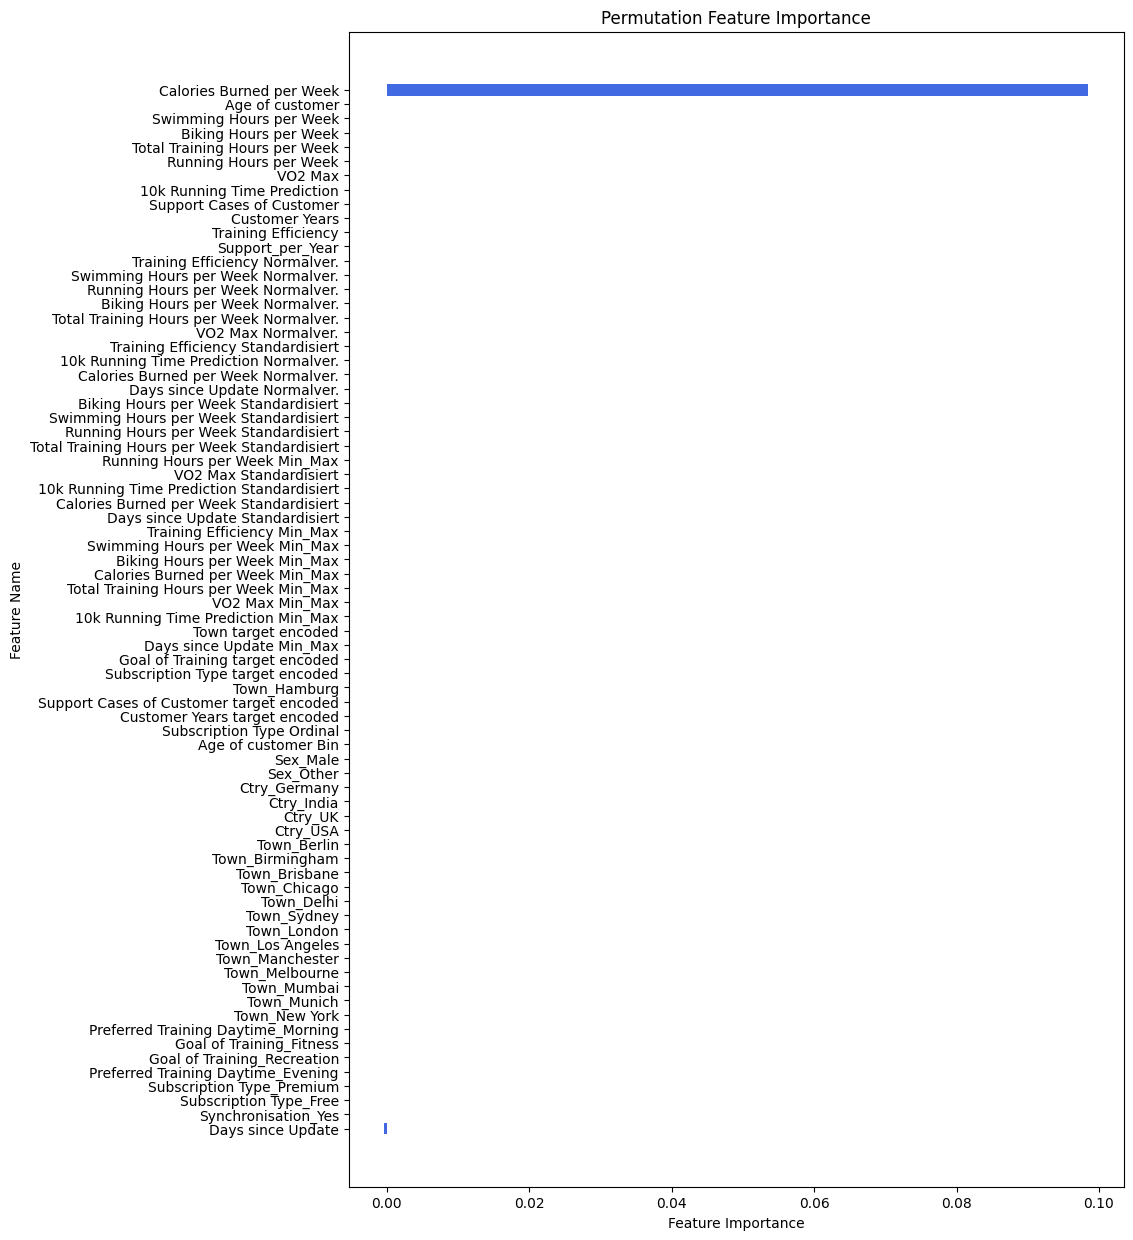

In [61]:
feature_importance_df = plot_permutation_importance(model, x_train_encoded, y_train, original_columns)

In [63]:
feature_importance_df.sort_values(by='Importance', ascending=False).head()

,Feature,Mapped Feature,Importance
7,Calories Burned per Week,Calories Burned per Week,0.09852
0,Age of customer,Age of customer,0.00000
1,Swimming Hours per Week,Swimming Hours per Week,0.00000
2,Biking Hours per Week,Biking Hours per Week,0.00000
4,Total Training Hours per Week,Total Training Hours per Week,0.00000


Kann ich jetzt nichts mit anfangen...

In [64]:
forward_selection_results = forward_selection(X_train, y_train, X_test, y_test, model=SVC(random_state=42), feature_groups=feature_groups, feature_order=feature_order)

In [65]:
forward_selection_results.sort_values(by="Accuracy", ascending=False).head(10)

,Selected Features,Accuracy,F1-Score
19,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.768817,0.726115
14,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.768817,0.726115
17,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.768817,0.726115
16,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.768817,0.726115
15,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.768817,0.726115
18,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.763441,0.717949
11,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.752688,0.705128
12,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.752688,0.705128
13,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.752688,0.705128
9,"[Age of customer Bin, VO2 Max, 10k Running Tim...",0.741935,0.688312


Die beste Feature-Kombination bei gleichzeitig so wenig Feature wie möglich besteht aus folgenden Spalten:

In [74]:
for i, feature in enumerate(forward_selection_results.iloc[14,0], start=1):
    print(f"{i}. {feature}")

1. Age of customer Bin
2. VO2 Max
3. 10k Running Time Prediction
4. Total Training Hours per Week Normalver.
5. Calories Burned per Week Normalver.
6. Ctry
7. Town
8. Goal of Training
9. Biking Hours per Week Normalver.
10. Running Hours per Week
11. Swimming Hours per Week Standardisiert
12. Support_per_Year
13. Customer Years target encoded
14. Support Cases of Customer
15. Subscription Type Ordinal


Das ist prinzipiell sinnig, da es keiner der Spalten enthält, die in der EDA keinen Zusammenhang mit dem Label gezeigt haben (`Synchronisation`, `Training Efficiency`, `Preferred Training Daytime`, `Sex` und `Days since Update`)  
Allerdings sind hier mehrere Variablen gleichzeitig enthalten, die einen Zusammenhang untereinander aufweisen (z.B. Die Trainingszeiten). Das sollte noch angeschaut werden.

In [75]:
# Modell mit bester Feature Kombination
X_train = X_train[forward_selection_results.iloc[14,0]]
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# One-Hot-Encoding nur für kategorische Features
if categorical_features:
    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first= True)

    # Sicherstellen, dass beide DataFrames die gleichen Spalten haben
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Modell trainieren
model = SVC(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

In [76]:
df_results = log_model_performance(model_name= 'SVC', durchlauf_name='Beste Feature Kombination', y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623
5,Beste Feature Kombination,SVC,0.768817,0.726115


#### Hyperparameter Tuning  
📌 **Wichtige Hyperparameter für das Tuning des SVC**

---

1️⃣ **`C` – Regularisierungsparameter**  
- **Steuert:** Die Regularisierung des Modells.  
- **Kleine Werte (`C` = 0.01, 0.1):** Stärkere Regularisierung → Einfacheres Modell, weniger Overfitting.  
- **Große Werte (`C` = 10, 100):** Weniger Regularisierung → Stärkeres Anpassen, höheres Overfitting-Risiko.  
- **Empfohlene Werte:** `loguniform(0.01, 10)`

---

2️⃣ **`kernel` – Kernel-Funktion**  
- **Steuert:** Die Art der Trennung.  
- **`linear`:** Für linear trennbare Daten.  
- **`rbf`:** Standardkernel, gut für nicht-lineare Trennungen.  
- **Empfohlene Werte:** `linear` oder `rbf` je nach Datentrennbarkeit.

---

3️⃣ **`gamma` – Kernel-Koeffizient (nur für `rbf`, `poly`, `sigmoid`)**  
- **Steuert:** Den Einflussbereich eines einzelnen Trainingspunkts.  
- **Kleine Werte (`gamma` = 0.01, 0.1):** Größerer Einflussbereich → Glattere Grenze.  
- **Große Werte (`gamma` = 1, 10):** Kleinere Einflussbereiche → Schärfere Grenze, mehr Overfitting.  
- **Empfohlene Werte:** `loguniform(0.01, 10)`

---

4️⃣ **`degree` – Polynomgrad (nur für `poly`)**  
- **Steuert:** Den Grad des Polynoms.  
- **Empfohlene Werte:** `3` (für die meisten Anwendungen).

---

5️⃣ **`coef0` – Offset (nur für `poly`, `sigmoid`)**  
- **Steuert:** Das Gewicht des Polynom- oder Sigmoidterms.  
- **Empfohlene Werte:** `0` oder kleine Werte (`0.1`).

---

6️⃣ **`max_iter` – Maximale Anzahl an Iterationen**  
- **Steuert:** Die maximale Iterationszahl des Optimierungsalgorithmus.  
- **Empfohlene Werte:** `[1000, 5000]`

In [77]:
X_train.head()

,Age of customer Bin,VO2 Max,10k Running Time Prediction,Total Training Hours per Week Normalver.,Calories Burned per Week Normalver.,Biking Hours per Week Normalver.,Running Hours per Week,Swimming Hours per Week Standardisiert,Support_per_Year,Customer Years target encoded,...,Town_London,Town_Los Angeles,Town_Manchester,Town_Melbourne,Town_Mumbai,Town_Munich,Town_New York,Town_Sydney,Goal of Training_Fitness,Goal of Training_Recreation
ID,,,,,,,,,,,,,,,,,,,,,
C0412,9,24.01,57.80,1.801703,1.877769,1.105755,6.11,2.076569,1,0.376147,...,False,False,False,False,False,False,False,False,False,False
C0540,8,35.59,52.30,1.443549,1.574794,1.064662,7.57,-0.250764,4,0.540541,...,False,False,True,False,False,False,False,False,True,False
C0103,4,52.34,46.49,-1.094843,-1.075427,-0.626174,1.63,-0.689883,0,0.376147,...,False,False,False,False,False,False,False,False,False,True
C0270,4,63.88,33.69,1.947691,2.074780,1.429703,5.96,1.844463,0,0.376147,...,False,False,False,False,False,False,False,True,True,False
C0213,9,26.32,52.34,0.544334,0.453168,0.644756,5.62,-1.285831,0,0.343750,...,False,True,False,False,False,False,False,False,False,False


In [78]:
X_test.head()

,Age of customer Bin,VO2 Max,10k Running Time Prediction,Total Training Hours per Week Normalver.,Calories Burned per Week Normalver.,Biking Hours per Week Normalver.,Running Hours per Week,Swimming Hours per Week Standardisiert,Support_per_Year,Customer Years target encoded,...,Town_London,Town_Los Angeles,Town_Manchester,Town_Melbourne,Town_Mumbai,Town_Munich,Town_New York,Town_Sydney,Goal of Training_Fitness,Goal of Training_Recreation
ID,,,,,,,,,,,,,,,,,,,,,
C0817,8,43.47,54.54,0.285026,0.273997,-0.406390,4.18,1.129326,0,0.280488,...,False,False,False,True,False,False,False,False,False,True
C0718,5,45.96,44.71,-1.766500,-1.590205,-0.845814,1.15,-1.398747,0,0.565217,...,False,False,False,False,False,False,False,False,False,True
C0034,2,72.54,31.81,2.009733,2.031949,1.954127,7.87,-0.802800,0,0.343750,...,False,False,False,False,False,False,False,False,False,False
C0419,0,54.94,39.77,-0.023149,-0.119718,0.618238,2.97,-1.398747,0,0.540541,...,False,False,False,False,False,False,False,True,False,True
C0207,7,37.04,51.07,0.683740,0.767196,-0.701014,5.44,2.239670,1,0.396226,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
# SVC Basic
model = SVC(random_state=42) 

# Parameterverteilungen für RandomizedSearchCV
param_dist = {
    'C': uniform(0.01, 10),  # Regularisierungsstärke optimieren
    'gamma': uniform(0.01, 10),  # Kernel-Koeffizient optimieren
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel-Funktion optimieren
    'degree': randint(2, 6),  # Grad des Polynoms für den 'poly' Kernel (nur relevant für poly)
    'coef0': uniform(0.0, 1.0),  # Offset für 'poly' und 'sigmoid' Kernel
    'max_iter': [1000, 5000]  # Falls das Modell nicht konvergiert
}

# Randomized Search mit 50 Iterationen und 5-Fold-CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Hyperparameter-Suche starten
random_search.fit(X_train, y_train)

# Beste Parameter anzeigen
best_params = random_search.best_params_
print("\nBeste Parameter:", best_params)

# Bestes Modell nutzen
best_model = random_search.best_estimator_

# Vorhersagen mit dem optimierten Modell
y_pred_tuned = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste Parameter: {'C': np.float64(1.0889142699330445), 'coef0': np.float64(0.03142918568673425), 'degree': 4, 'gamma': np.float64(4.763702231821117), 'kernel': 'linear', 'max_iter': 5000}


c:\Users\miche\anaconda3\envs\analytics\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [84]:
df_results = log_model_performance(
    model_name="SVC", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred_tuned, 
    y_test=y_test
)

df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623
5,Beste Feature Kombination,SVC,0.768817,0.726115
6,Hyperparameter-Tuning,SVC,0.736559,0.729282


#### Fazit  
.......

## Dichtebasierte Modelle

### K-neaest neighbors (KNN)  
K-nearest Neighbors (KNN) ist ein einfaches, aber leistungsstarkes Klassifikations- und Regressionsmodell, das auf dem Prinzip basiert, dass ähnliche Datenpunkte in der Nähe voneinander liegen. Bei der Klassifikation betrachtet KNN für einen gegebenen Testpunkt die k nächsten Trainingsbeispiele und weist dem Testpunkt die häufigste Klasse der Nachbarn zu. KNN verwendet keine expliziten Trainingsphasen, sondern speichert die Trainingsdaten und trifft Vorhersagen basierend auf den nächsten Nachbarn während der Vorhersagephase. Es ist besonders nützlich bei kleineren Datensätzen oder Problemen, bei denen die Daten keine klare lineare Trennung aufweisen. KNN kann für Klassifikationsprobleme auch mit verschiedenen Distanzmaßen (wie euklidisch, Manhattan) und Gewichtungsstrategien (z. B. uniform oder distance) verwendet werden. Bei größeren Datensätzen ist KNN sehr rechenintensiv. Aufgrund der hier zugrundeliegenden Datengröße sollte dies aber keine Probleme bereiten.

In [86]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline

In [87]:
y_pred, model_name, run_name, model, x_train_encoded, original_columns = train_baseline_model(KNeighborsClassifier(), X_train, y_train, X_test)

In [88]:
df_results = log_model_performance(model_name= model_name, durchlauf_name=run_name, y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623
5,Beste Feature Kombination,SVC,0.768817,0.726115
6,Hyperparameter-Tuning,SVC,0.736559,0.729282
7,Baseline,KNeighborsClassifier,0.634409,0.521127


#### Feature Selection

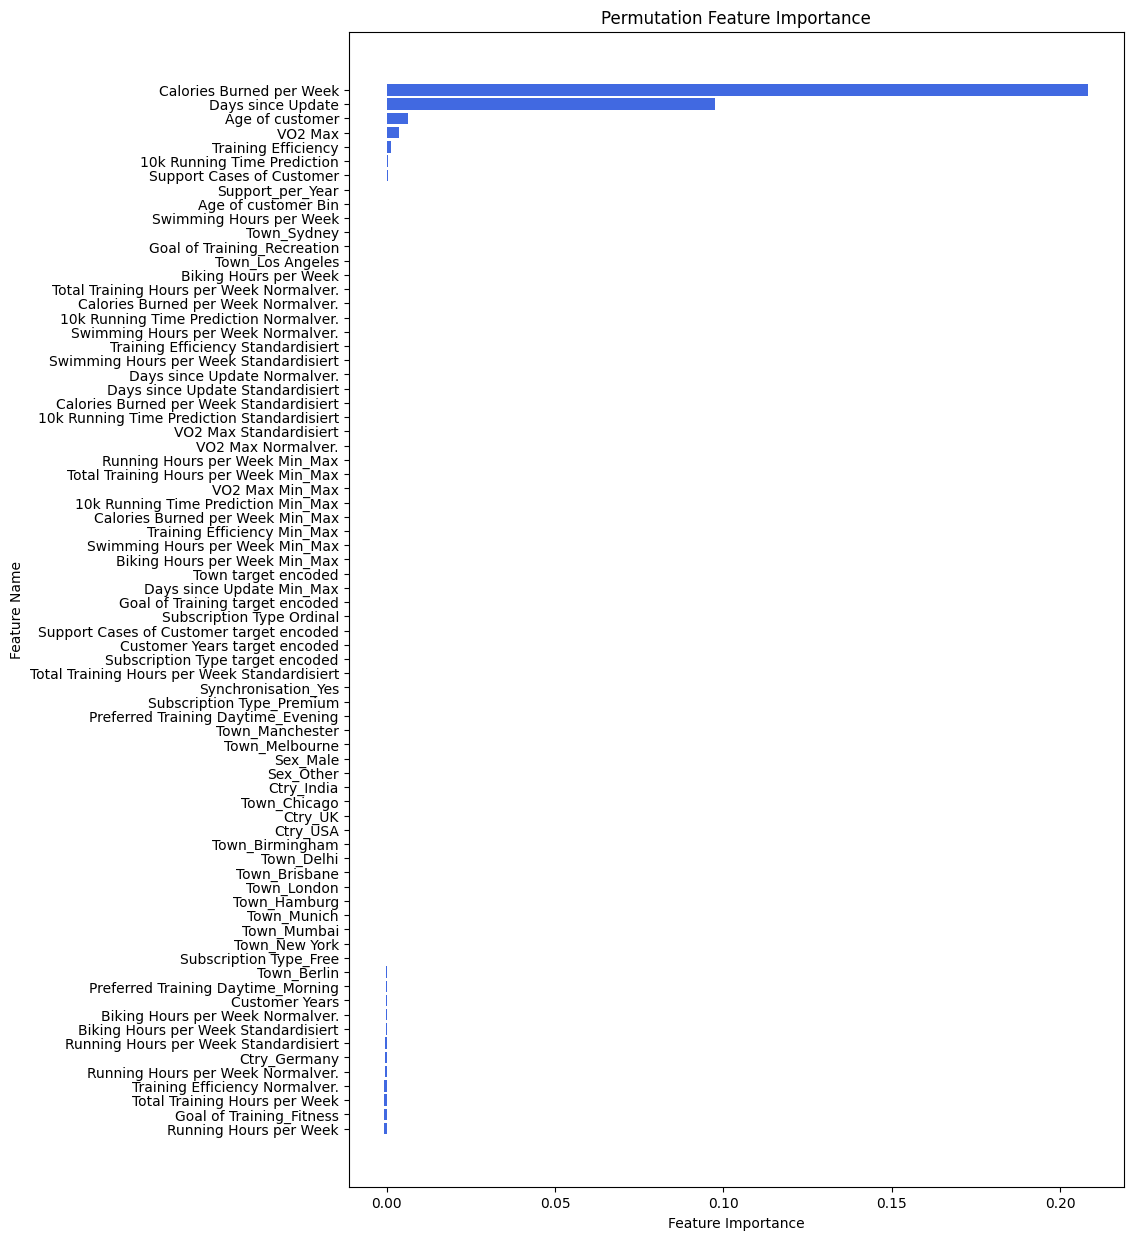

In [89]:
feature_importance_df = plot_permutation_importance(model, x_train_encoded, y_train, original_columns)

Kann ich auch nichts mit anfangen - Müsste ich mich reinlesen

In [90]:
forward_selection_results = forward_selection(X_train, y_train, X_test, y_test, model=KNeighborsClassifier(), feature_groups=feature_groups, feature_order=feature_order)

In [91]:
forward_selection_results.sort_values(by="Accuracy", ascending=False).head(10)

,Selected Features,Accuracy,F1-Score
16,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
13,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
14,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
11,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
15,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
12,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.736559,0.683871
8,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.725806,0.666667
1,"[Age of customer Bin, VO2 Max Standardisiert]",0.725806,0.638298
10,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.725806,0.666667
7,"[Age of customer Bin, VO2 Max Standardisiert, ...",0.725806,0.670968


Die beste Feature-Kombination bei gleichzeitig so wenig Feature wie möglich besteht aus folgenden Spalten:

In [93]:
for i, feature in enumerate(forward_selection_results.iloc[11,0], start=1):
    print(f"{i}. {feature}")

1. Age of customer Bin
2. VO2 Max Standardisiert
3. 10k Running Time Prediction
4. Total Training Hours per Week Standardisiert
5. Calories Burned per Week Min_Max
6. Ctry
7. Town target encoded
8. Goal of Training
9. Biking Hours per Week Min_Max
10. Running Hours per Week Min_Max
11. Swimming Hours per Week Min_Max
12. Support_per_Year


Das ist prinzipiell sinnig, da es keiner der Spalten enthält, die in der EDA keinen Zusammenhang mit dem Label gezeigt haben (`Synchronisation`, `Training Efficiency`, `Preferred Training Daytime`, `Sex` und `Days since Update`)  
Allerdings sind hier mehrere Variablen gleichzeitig enthalten, die einen Zusammenhang untereinander aufweisen (z.B. Die Trainingszeiten). Das sollte noch angeschaut werden.

In [94]:
# Modell mit bester Feature Kombination
X_train = X_train[forward_selection_results.iloc[11,0]]
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# One-Hot-Encoding nur für kategorische Features
if categorical_features:
    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first= True)

    # Sicherstellen, dass beide DataFrames die gleichen Spalten haben
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Modell trainieren
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

In [95]:
df_results = log_model_performance(model_name= 'KNeighborsClassifier', durchlauf_name='Beste Feature Kombination', y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623
5,Beste Feature Kombination,SVC,0.768817,0.726115
6,Hyperparameter-Tuning,SVC,0.736559,0.729282
7,Baseline,KNeighborsClassifier,0.634409,0.521127
8,Beste Feature Kombination,KNeighborsClassifier,0.736559,0.683871


#### Hyperparameter Tuning  
📌 **Wichtige Hyperparameter für das Tuning von KNN**  

---

1️⃣ **`n_neighbors` – Anzahl der Nachbarn**  
- **Steuert:** Wie viele Nachbarn für die Vorhersage berücksichtigt werden.  
- **Kleine Werte (`n_neighbors` = 1, 3):** Weniger Nachbarn → Das Modell wird empfindlicher gegenüber Rauschen und könnte zu Overfitting neigen.  
- **Große Werte (`n_neighbors` = 10, 20):** Mehr Nachbarn → Das Modell wird stabiler und generalisierter, kann aber zu Underfitting führen.  
- **Empfohlene Werte:** `randint(1, 20)` (z. B. `5, 10`)

---

2️⃣ **`weights` – Gewichtung der Nachbarn**  
- **Steuert:** Wie die Nachbarn gewichtet werden.  
- **`uniform`:** Alle Nachbarn haben das gleiche Gewicht.  
- **`distance`:** Nachbarn, die näher am Testpunkt liegen, haben ein höheres Gewicht.  
- **Empfohlene Werte:** `uniform` oder `distance`, je nach dem Ausmaß der benötigten Flexibilität.

---

3️⃣ **`algorithm` – Algorithmus für die Nachbarschaftssuche**  
- **Steuert:** Welcher Algorithmus zur Bestimmung der nächsten Nachbarn verwendet wird.  
- **`auto`:** Wählt den besten Algorithmus basierend auf den Daten.  
- **`ball_tree`, `kd_tree`:** Effektiver bei großen Datensätzen mit niedrigdimensionalen Daten.  
- **`brute`:** Brute-Force-Suche ohne spezielle Datenstruktur (nützlich bei kleinen Datensätzen).  
- **Empfohlene Werte:** `auto`, da es den besten Algorithmus automatisch auswählt.

---

4️⃣ **`leaf_size` – Größe der Blätter (nur für `ball_tree` und `kd_tree`)**  
- **Steuert:** Die Größe der Blätter in den zugrunde liegenden Bäumen.  
- **Kleine Werte (`leaf_size` = 10, 20):** Kleinere Blätter → Höhere Genauigkeit, aber langsamer.  
- **Große Werte (`leaf_size` = 30, 50):** Schnellere Berechnungen, aber weniger genau.  
- **Empfohlene Werte:** `randint(10, 50)`.

---

5️⃣ **`p` – Distanzmaß (Minkowski)**
- **Steuert:** Den Typ der Distanzmessung für die Nachbarn.  
- **`p=1` (Manhattan-Distanz):** Abstand basierend auf der Summe der absoluten Differenzen der Koordinaten.  
- **`p=2` (Euklidische Distanz):** Abstand basierend auf der Quadratwurzel der Summe der quadrierten Differenzen der Koordinaten.  
- **Empfohlene Werte:** `1` (für Manhattan) oder `2` (für Euklidisch), je nach dem Problem.

---

6️⃣ **`metric` – Distanzmaß**  
- **Steuert:** Die Distanzfunktion zur Berechnung der Nähe.  
- **`minkowski`:** Standard, verwendet `p` als Parameter.  
- **`euclidean`, `manhattan`:** Alternativen zu Minkowski, die spezifische Distanzfunktionen definieren.  
- **Empfohlene Werte:** `minkowski`, aber bei Bedarf auch `euclidean` oder `manhattan`.


In [96]:
X_train.head()

,Age of customer Bin,VO2 Max Standardisiert,10k Running Time Prediction,Total Training Hours per Week Standardisiert,Calories Burned per Week Min_Max,Town target encoded,Biking Hours per Week Min_Max,Running Hours per Week Min_Max,Swimming Hours per Week Min_Max,Support_per_Year,Ctry_Germany,Ctry_India,Ctry_UK,Ctry_USA,Goal of Training_Fitness,Goal of Training_Recreation
ID,,,,,,,,,,,,,,,,
C0412,9,-1.924607,57.80,2.042520,0.797188,0.460317,0.590317,0.514743,0.555667,1,False,False,False,False,False,False
C0540,8,-1.068513,52.30,1.550662,0.727868,0.192982,0.578523,0.637742,0.183551,4,False,False,True,False,True,False
C0103,4,0.169794,46.49,-1.055783,0.215719,0.304348,0.188082,0.137321,0.113340,0,False,False,True,False,False,True
C0270,4,1.022931,33.69,2.252165,0.843283,0.383333,0.687151,0.502106,0.518556,0,False,False,False,False,True,False
C0213,9,-1.753832,52.34,0.454060,0.488942,0.642857,0.464308,0.473463,0.018054,0,False,False,False,True,False,False


In [98]:
X_test.head()

,Age of customer Bin,VO2 Max Standardisiert,10k Running Time Prediction,Total Training Hours per Week Standardisiert,Calories Burned per Week Min_Max,Town target encoded,Biking Hours per Week Min_Max,Running Hours per Week Min_Max,Swimming Hours per Week Min_Max,Support_per_Year,Ctry_Germany,Ctry_India,Ctry_UK,Ctry_USA,Goal of Training_Fitness,Goal of Training_Recreation
ID,,,,,,,,,,,,,,,,
C0817,8,-0.485954,54.54,0.173862,0.453556,0.338235,0.228430,0.352148,0.404213,0,False,False,False,False,False,True
C0718,5,-0.301872,44.71,-1.501278,0.140585,0.265625,0.150838,0.096883,0.000000,0,False,True,False,False,False,True
C0034,2,1.663154,31.81,2.342876,0.833195,0.304348,0.858473,0.663016,0.095286,0,False,False,True,False,False,False
C0419,0,0.362008,39.77,-0.138589,0.378739,0.383333,0.457480,0.250211,0.000000,0,False,False,False,False,False,True
C0207,7,-0.961316,51.07,0.611294,0.552884,0.192982,0.175047,0.458298,0.581745,1,False,False,True,False,True,False


In [100]:
# Modell initialisieren
model = KNeighborsClassifier()

# Parameterverteilungen für RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 20),  # Anzahl der Nachbarn optimieren
    'weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn optimieren
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithmus für Nachbarschaftssuche
    'leaf_size': randint(10, 50),  # Blattgröße für ball_tree und kd_tree
    'p': [1, 2],  # Distanzmaß optimieren (1 = Manhattan, 2 = Euklidisch)
    'metric': ['minkowski', 'euclidean', 'manhattan'],  # Distanzmaß
}

# Randomized Search mit 50 Iterationen und 5-Fold-CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Hyperparameter-Suche starten
random_search.fit(X_train, y_train)

# Beste Parameter anzeigen
best_params = random_search.best_params_
print("\nBeste Parameter:", best_params)

# Bestes Modell nutzen
best_model = random_search.best_estimator_

# Vorhersagen mit dem optimierten Modell
y_pred_tuned = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste Parameter: {'algorithm': 'brute', 'leaf_size': 12, 'metric': 'minkowski', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}


c:\Users\miche\anaconda3\envs\analytics\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [101]:
df_results = log_model_performance(
    model_name="KNeighborsClassifier", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred_tuned, 
    y_test=y_test
)

df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,LogisticRegression,0.747312,0.675862
1,Featureimportance > 0,LogisticRegression,0.763441,0.702703
2,Beste Feature Kombination,LogisticRegression,0.801075,0.754967
3,Hyperparameter-Tuning,LogisticRegression,0.784946,0.733333
4,Baseline,SVC,0.634409,0.442623
5,Beste Feature Kombination,SVC,0.768817,0.726115
6,Hyperparameter-Tuning,SVC,0.736559,0.729282
7,Baseline,KNeighborsClassifier,0.634409,0.521127
8,Beste Feature Kombination,KNeighborsClassifier,0.736559,0.683871
9,Hyperparameter-Tuning,KNeighborsClassifier,0.725806,0.643357


#### Fazit